# Data Exploration

In [44]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import json
from datetime import datetime
import random

from sklearn.preprocessing import PowerTransformer, StandardScaler, RobustScaler, MinMaxScaler


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization,Dropout, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras import losses
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
import xgboost as xgb
from catboost import CatBoostRegressor

from scipy.special import boxcox1p, inv_boxcox1p
from scipy import stats
from scipy.stats import norm, skew

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import PolynomialFeatures

from pycaret.regression import * 


import lightgbm as lgb
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, Ridge

import optuna 
import joblib
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.mixture import GaussianMixture


import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 100)

sns.set_style("white")
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
plt.rcParams['figure.figsize'] = [16.0, 10.0]

def mean_absolute_percentage_error(y_pred, y_true):
    y_true = np.where(y_true == 0, 0.0000000001, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true))

indicators = pd.read_excel("indicadores_ec.xlsx",engine='openpyxl')
indicators['Fecha']  = indicators['Fecha'].astype(str) 

ec_indicators = ['ICC', 'IEC', 'ICE', 'ISE']
for indicator in ec_indicators:
    indicators[indicator] = indicators[indicator].apply(lambda x: (x - np.min(indicators[indicator])) / (np.max(indicators[indicator]) - np.min(indicators[indicator])) )


# Preprocessing class

In [1]:
class DataFramePreProcessor:
    
    def __init__(self, dataframe, test=False):
        self.test = test
        self.original_dataframe = dataframe.copy()
        self.modeling_dataframe = None

    
    
    def handleMissingData(self, dataframe):
        dataframe['ingreso_final'] = dataframe['ingreso_final'].fillna(0)
        #dataframe['ind'] = dataframe['ind'].fillna(0)
        dataframe['tipo_vivienda'] = dataframe['tipo_vivienda'].fillna("NO INFORMA")
        dataframe['categoria'] = dataframe['categoria'].fillna("6")
        dataframe['estado_civil'] =dataframe['estado_civil'].fillna("NI")
        #dataframe['departamento_residencia'] = dataframe['departamento_residencia'].fillna("SIN INFORMACION")
        #dataframe['ocupacion'] = dataframe['ocupacion'].fillna("Otro")
        dataframe['ind_mora_vigente']  = dataframe['ind_mora_vigente'].fillna("N") 
        return dataframe
    
    
    def columnFilter(self, dataframe):
        to_drop = [
            "Unnamed: 0",
            "id_cli",
            "pol_centr_ext",
            "ult_actual",
            "cant_mora_30_tdc_ult_3m_sf",
            "cant_mora_30_consum_ult_3m_sf",
            #"ind",
            "cat_ingreso",
            "departamento_residencia",
            "ocupacion",
            "estado_civil",
            "tipo_vivienda",
            "nivel_academico",
            "rep_calif_cred",
            "tiene_ctas_activas",
            "mora_max"
            
        ]
        
            
        dataframe = dataframe.drop(to_drop,axis=1, errors='ignore')
        return dataframe
    
    
    # Borrar filas deacuerdo a cierta logica de negocio
    def rowFilter(self, dataframe):
        cut = 0.999999
        return  dataframe[
                (dataframe['gasto_familiar'] >= 50000) &
                (dataframe['gasto_familiar'] <= 2500000) &
                (dataframe['gasto_familiar'] < np.quantile(dataframe['gasto_familiar'], cut)) &
                (dataframe['ingreso_final'] < np.quantile(dataframe['ingreso_final'], cut)) &
                (dataframe['cupo_total_tc'] < np.quantile(dataframe['cupo_total_tc'], cut)) & # Percentil 99%
                (dataframe['cuota_tc_bancolombia'] < np.quantile(dataframe['cuota_tc_bancolombia'], cut)) & # percentil 99.99%
                (dataframe['cuota_de_vivienda'] < np.quantile(dataframe['cuota_de_vivienda'], cut)) &# Percentil 99.99%
                (dataframe['cuota_de_consumo'] < np.quantile(dataframe['cuota_de_consumo'], cut)) & # percentil 99%
                (dataframe['cuota_rotativos'] < np.quantile(dataframe['cuota_rotativos'], cut))& # percentil 99.99%
                (dataframe['cuota_tarjeta_de_credito'] < np.quantile(dataframe['cuota_tarjeta_de_credito'], cut)) & 
                (dataframe['cuota_de_sector_solidario'] < np.quantile(dataframe['cuota_de_sector_solidario'], cut)) &
                (dataframe['cuota_sector_real_comercio'] < np.quantile(dataframe['cuota_sector_real_comercio'], cut)) &# Percentil 99.5%
                (dataframe['cuota_libranza_sf'] < np.quantile(dataframe['cuota_libranza_sf'], cut)) & # Percentil 99
                (dataframe['ingreso_segurida_social'] < np.quantile(dataframe['ingreso_segurida_social'], cut)) & # percentil 99.9
                (dataframe['ingreso_nomina'] < np.quantile(dataframe['ingreso_nomina'], cut)) &
                (dataframe['saldo_prom3_tdc_mdo'] < np.quantile(dataframe['saldo_prom3_tdc_mdo'], cut)) &
                (dataframe['saldo_no_rot_mdo'] < np.quantile(dataframe['saldo_no_rot_mdo'], cut)) &
                (dataframe['cuota_cred_hipot'] < np.quantile(dataframe['cuota_cred_hipot'], cut)) &
                (dataframe['mediana_nom3'] < np.quantile(dataframe['mediana_nom3'], cut)) &
                (dataframe['mediana_pen3'] < np.quantile(dataframe['mediana_pen3'], cut)) &
                (dataframe['cuota_tc_mdo'] < np.quantile(dataframe['cuota_tc_mdo'], cut)) &
                (dataframe['ingreso_nompen'] < np.quantile(dataframe['ingreso_nompen'], cut)) &
                (dataframe['cant_oblig_tot_sf'] <= 15) &
                (dataframe['ctas_activas'] < 5) &
                (dataframe['nro_tot_cuentas'] < 5) 
               # (dataframe['ind_mora_vigente'] != 'NApl') 
               # (dataframe['ind'] < np.quantile(dataframe['ind'], cut))
              #  ~(dataframe['departamento_residencia'].isin(['MADRID', 'ESTADO DE LA FLORIDA', 'VAUPES']))
            ] 
    
    def oneEncodeVariables(self):
        pass
    
    def processVars(self, dataframe):
        
        # Transformacion demograficas
        dataframe['genero'] = np.where(dataframe['genero'] == 'M', 0, 1)
        #dataframe['edad'] = np.where(dataframe['edad'] < 18, 18,
        #                            np.where(dataframe['edad'] > 80, 80, dataframe['edad']
        #                            ))
       # dataframe['educacion_grupo'] = np.where(
       #     dataframe['nivel_academico'].isin(['PRIMARIO', 'UNIVERSITARIO', 'ESPECIALIZACION']),1,0
       #)
        #dataframe['ind_caida_gasto'] = np.where(dataframe['periodo'] == 202004,1,0)
        #dataframe['ind_caida_cuota'] = np.where(dataframe['periodo'] == 202009,1,0)
        #dataframe['tipo_vivienda'] =  np.where(dataframe['tipo_vivienda'].isin(["\\N", "NO INFORMA"]),"OTRO",
        #                                       np.where(dataframe['tipo_vivienda'].isin(['FAMILIAR','ALQUILADA']), "FAM_ALQ",
        #                                                dataframe['tipo_vivienda']
        #                                               )
        #                                     )
        dataframe['categoria']=np.where(dataframe['categoria']=='\\N', "6",dataframe['categoria'])
        dataframe['categoria']=dataframe['categoria'].astype(float).astype(int)
        #dataframe['ocupacion']=np.where(dataframe['ocupacion'].isin(
        #        ["\\N", "Agricultor", "Ganadero", 'Vacío', "Ama de casa", "Sin Ocupacion Asignada"]), "Otro",
        #                               np.where(dataframe['ocupacion'] == "Pensionado", "Jubilado", dataframe['ocupacion']
        #                                       ))
        
        #dataframe['departamento_residencia'] = \
        #    np.where(
        #        dataframe['departamento_residencia'].isin(['\\N', 'NARIÑO', 'NARI#O', 'VAUPES','MADRID', 'ESTADO DE LA FLORIDA']),
        #        "SIN INFORMACION", dataframe['departamento_residencia'] )
        
        #dataframe['es_ciudad_principal'] = np.where(
        #    dataframe['departamento_residencia'].isin(['BOGOTA D.C.', 'ANTIOQUIA', 'VALLE', 'CUNDINAMARCA']), 1,0)  
        #dataframe['estado_civil'] = np.where(dataframe['estado_civil'].isin(['NI', 'VIU', 'OTRO', 'NI', 'DIV']), 
        #                                     "OTRO", dataframe['estado_civil'])
        
        #dataframe['ind_mora_vigente'] = np.where(dataframe['ind_mora_vigente'] == "S", 1, 0)
        dataframe['convenio_lib'] = np.where(dataframe['convenio_lib'] == 'S', 1, 0)
        # Transformacion finacieras
        dataframe['ingreso_calculado'] =  dataframe['ingreso_segurida_social']  +  \
                                          dataframe[['ingreso_nompen', 'ingreso_nomina']].max(axis=1)
        dataframe['ingreso_corr'] = dataframe[['ingreso_final', 'ingreso_calculado']].max(axis=1)
        
        dataframe['cuota_cred_hipot'] = dataframe[['cuota_cred_hipot', 'cuota_de_vivienda']].max(axis=1)
        dataframe['cuota_de_consumo'] =np.where(dataframe['cuota_de_consumo'] < 0, 0, dataframe['cuota_de_consumo'])
        dataframe['cuota_cred_hipot'] =np.where(dataframe['cuota_cred_hipot'] < 0, 0, dataframe['cuota_cred_hipot']) 
        
        dataframe['total_cuota'] = dataframe['cuota_cred_hipot'] + \
                                   dataframe['cuota_tarjeta_de_credito'] + \
                                   dataframe['cuota_de_consumo'] + \
                                   dataframe['cuota_rotativos'] + \
                                   dataframe['cuota_de_sector_solidario'] + \
                                   dataframe['cuota_libranza_sf'] + \
                                   dataframe['cuota_tarjeta_de_credito'] + \
                                   dataframe['cuota_tc_bancolombia']
        
        dataframe['saldo_favor']  = np.where(dataframe['total_cuota']<0, dataframe['total_cuota']*-1, 0)
        dataframe['total_cuota'] = np.where(dataframe['total_cuota']<0,0, dataframe['total_cuota'])

        #dataframe['cat_edad'] = np.where(dataframe['edad'] < 30, "M30",
        #                          np.where(dataframe['edad'] < 40, "M30_40",
        #                                  np.where(dataframe['edad'] < 50, "M40_50", "M60")))
                
        pct_vars = [
            'cuota_cred_hipot',
            'cuota_tarjeta_de_credito',
            'cuota_de_consumo',
            'cuota_rotativos',
            'cuota_sector_real_comercio',
            'cuota_de_sector_solidario',
            'cuota_tc_bancolombia',
            'cuota_libranza_sf',
            'cupo_total_tc',
            'cupo_tc_mdo'
        ]
        
        for var in pct_vars:
            dataframe[f"{var}_pct"] = dataframe[var] / dataframe['ingreso_corr']  * 100
            dataframe[f"{var}_pct"] = dataframe[f"{var}_pct"].replace(dict.fromkeys([np.nan, np.inf, -np.inf], 0))
            #dataframe[f"{var}_2"]   = dataframe[var] ** 2
    
        dataframe['obl_total_pct'] = dataframe['cuota_cred_hipot_pct'] + \
                                     dataframe['cuota_tarjeta_de_credito_pct'] +\
                                     dataframe['cuota_de_consumo_pct'] + \
                                     dataframe['cuota_rotativos_pct'] + \
                                     dataframe['cuota_sector_real_comercio_pct'] + \
                                     dataframe['cuota_de_sector_solidario_pct'] + \
                                     dataframe['cuota_tc_bancolombia_pct'] + \
                                     dataframe['cuota_rotativos_pct'] 
        
                                    

        #dataframe['sobre_endeudado'] = np.where(dataframe['obl_total_pct'] > 100, 1, 0)
        dataframe['total_cupo'] = dataframe['cupo_total_tc'] + dataframe['cupo_tc_mdo']
        #dataframe['ingreso_cero'] = np.where(dataframe['ingreso_corr'] == 0, 1, 0)
        
        # Variables de interaccion
        dataframe['interact_ing_gen']  = dataframe['genero'] * dataframe['ingreso_corr']
        dataframe['interact_ing_ed']  = dataframe['edad'] * dataframe['ingreso_corr']
        dataframe['interact_cup_gen']  = dataframe['genero'] * dataframe['total_cupo']
        dataframe['interact_cup_ed']  = dataframe['edad'] * dataframe['total_cupo']
        dataframe['interact_obl_gen'] = dataframe['genero'] * dataframe['obl_total_pct']
        dataframe['interact_obl_ed']  = dataframe['edad'] * dataframe['obl_total_pct']    
        #dataframe['interact_caida_ing'] = dataframe['ingreso_corr']*dataframe['ind_caida_gasto']
        #dataframe['interact_mora_ing'] = dataframe['ingreso_corr']*dataframe['ind_mora_vigente']
        #dataframe['interact_mora_cuota'] = dataframe['total_cuota']*dataframe['ind_mora_vigente']
        #dataframe['interact_caida_cuota'] = dataframe['ind_caida_cuota'] * dataframe['total_cuota']
        
        #dataframe['ingreso_geo_alto']  = np.where(dataframe['ingreso_corr'] < 14.90, 1, 0) # ALgo mas tecnico

    
        #dataframe['pc25'] = np.where(dataframe['ingreso_corr'] <= np.quantile(dataframe['ingreso_corr'],0.25), 1, 0)
        #dataframe['pc75'] = np.where(dataframe['ingreso_corr'] >= np.quantile(dataframe['ingreso_corr'],0.75), 1, 0)

        # variables al cuadrado
        
        #dataframe['edad_2'] = dataframe['edad']**2
        dataframe['total_cuota_2']  =dataframe['total_cuota']**2
        #dataframe['total_cupo_2']  =dataframe['total_cupo']**2
        #dataframe['obl_total_pct_2'] = dataframe['obl_total_pct']**2
        #dataframe['ingreso_corr2'] = dataframe['ingreso_corr']**2 
        
        
        # Raiz de las variables
        
        #dataframe['cupo_pct'] = dataframe['total_cupo']/dataframe['ingreso_corr']
        #dataframe['cupo_disponible'] = dataframe['total_cupo'] - dataframe['cuota_tarjeta_de_credito'] - \
         #                              dataframe['cuota_tc_bancolombia']
        #dataframe['liquidez'] = dataframe['cupo_disponible'] + dataframe['ingreso_corr']
        #dataframe['liquidez_c'] = dataframe['total_cupo'] + dataframe['ingreso_corr']
        #dataframe['cuota_pct_cupo'] = (dataframe['cuota_tarjeta_de_credito'] + dataframe['cuota_tc_bancolombia']) / dataframe['total_cupo']
        #dataframe['ind_corregido'] = dataframe['ingreso_corr'] - dataframe['total_cuota'] - dataframe['ingreso_corr']*0.1
        #dataframe['ratio_cupo'] = dataframe['cupo_tc_mdo']/dataframe['cupo_tc_mdo']
        
        dataframe.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
        dataframe['periodo'] = dataframe['periodo'].astype(str)
        dataframe = dataframe.merge(indicators.drop(['inflacion'], axis=1), left_on='periodo', right_on='Fecha')
        
        if not self.test:
            #dataframe['gasto_familiar'] = np.where(dataframe['gasto_familiar'] <= 0,
            #                                       1,
            #                                      dataframe['gasto_familiar'])
            
            dataframe['log_gasto_familiar'] = np.log1p(dataframe['gasto_familiar']) 
            #dataframe['log_gasto_familiar'] = np.sqrt(dataframe['gasto_familiar'])
            numeric_feats = dataframe.drop(['gasto_familiar', 'log_gasto_familiar'], axis=1).dtypes[
                    (dataframe.dtypes == "float64")].index
        else:
            numeric_feats = dataframe.dtypes[
                    (dataframe.dtypes == "float64")].index
            
        skewed_feats = dataframe[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
        skewness = pd.DataFrame({'Skew' :skewed_feats})
        skewness = skewness[abs(skewness) > 0.75]       
        skewed_features = skewness.index
        lam = 0.5
        PT_transformer = PowerTransformer()
        for feat in skewed_features:
             dataframe[feat] = boxcox1p(dataframe[feat], lam)        
             #dataframe[feat] = PT_transformer.fit_transform(dataframe[feat].values.reshape(-1,1))
        
            
        cat_vars = [
            #'mora_max',
            #'estado_civil',
            #'rep_calif_cred',
            #'ocupacion',
            #'tipo_vivienda',
            #'nivel_academico',
            #'departamento_residencia',
            #"ind_mora_vigente",
            #"cat_edad",
            #"periodo"
        ]
        if cat_vars:
            dummified = []
            for var in cat_vars:            
                dummified.append(
                    pd.get_dummies(dataframe[var], drop_first=True, prefix=var)
                )

            dummified = pd.concat(dummified, axis=1)
            dataframe = pd.concat([dataframe.drop(cat_vars, axis=1),dummified], axis=1)
            
        cluster_variables = [
            'cuota_cred_hipot',
            'cuota_tarjeta_de_credito',
            'cuota_de_consumo',
            'cuota_rotativos',
            'cuota_sector_real_comercio',
            'cuota_de_sector_solidario',
            'cuota_tc_bancolombia',
            'cuota_libranza_sf',
            "ingreso_corr",
            "cupo_tc_mdo",
            "nro_tot_cuentas",
            "mediana_nom3",
            "mediana_pen3",
            "cant_oblig_tot_sf",
            "saldo_prom3_tdc_mdo",
            "cupo_total_tc",
            "saldo_no_rot_mdo"
        ]
            
        #gmm =GaussianMixture(n_components=5, random_state=1).fit_predict(dataframe[cluster_variables])
        #dataframe['cluster'] = gmm
        ## Final cleaning
        
        dataframe.drop(["ingreso_final", "ingreso_calculado",
                        "cuota_de_vivienda", 
                        "gasto_familiar",
                        "cupo_total_tc_pct", "cupo_tc_mdo_pct", "cupo_disponible",
                        #"cupo_tc_mdo",
                        #"cupo_total_tc",
                        "ingreso_nompen", "ingreso_nomina", "ingreso_segurida_social",
                        "ingreso_cero",
                        "tenencia_tc", # Alta correlacion con cuota tarjeta de credito
                        "ctas_activas", # Alta correlacion con nto_tot_cuentas
                        "cuota_cred_hipot_pct", #altta correlacion con cuota credito hipotecario
                        "cuota_de_consumo_pct", #Alta correlacion con cuta de consumo
                        "cuota_rotaticos_pct", # Alta correlacion con cuota de rotativos
                        "cuota_tarjeta_de_credito_pct",
                        "cuota_de_sector_solidario_pct",
                        "cuota_sector_real_comercio_pct",
                        "cuota_libranza_sf_pct",
                        "cuota_tc_bancolombia_pct",
                        "cuota_rotativos_pct",
                        # REVISAR BIEN
                        #"saldo_no_rot_mdo",
                        "total_cuota",
                        "convenio_lib",
                        "ind_mora_vigente",
                        #'cuota_cred_hipot',
                        #'cuota_tarjeta_de_credito',
                        #'cuota_de_consumo',
                        #'cuota_rotativos',
                        #'cuota_sector_real_comercio',
                        #'cuota_de_sector_solidario',
                        #'cuota_tc_bancolombia',
                        #'cuota_libranza_sf',
                        "tiene_consumo",
                        #"cuota_tc_mdo",
                        "tiene_crediagil",
                        #"nivel_academico",
                        "total_cupo",
                        #"genero",
                        #"nro_tot_cuentas",
                        #"mediana_nom3",
                        #"mediana_pen3",
                        #"cant_oblig_tot_sf",
                        #"saldo_prom3_tdc_mdo",
                        #"categoria",
                        "cuota_pct_cupo",
                        #"edad",
                        #"ind_caida_gasto",
                        #"ind_caida_cuota",
                        "Fecha",
                        #"periodo"
                        "mora_max",
                       ], axis=1, inplace=True,  errors='ignore')

        return dataframe
    
    def process(self):
        
        complete_df = self.columnFilter(
                self.handleMissingData(self.original_dataframe)
        )
        if not self.test:
            filtered_df = self.rowFilter(complete_df)
            grown_df    = self.processVars(filtered_df)
        else:
            grown_df    = self.processVars(complete_df)
        self.modeling_dataframe = grown_df
        
        return self.modeling_dataframe
        

# Hyperparameter tuning class

In [490]:
class ModelTuning:
    
    
    def __init__(self, X, y, algorithm):
        self.X = X
        self.y = y
        self.algorithm = algorithm
        self.best_params= None
    
    def objective(self, trial: Trial, X, y, algorithm) -> float:
        
        if algorithm == 'xgb':
                params = {
                    "n_estimators" : trial.suggest_int('n_estimators', 50, 200),
                    'max_depth':trial.suggest_int('max_depth', 2, 20),
                    'reg_alpha':trial.suggest_int('reg_alpha', 0, 8),
                    'reg_lambda':trial.suggest_int('reg_lambda', 0, 8),
                    'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                    'gamma':trial.suggest_int('gamma', 0, 5),
                    'learning_rate':trial.suggest_loguniform('learning_rate',0.01,0.5),
                    'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
                    'nthread' : -1
                }
                model_ = xgb.XGBRegressor(**params)
                
        elif algorithm == 'catboost':
            params = {
                "n_estimators" : trial.suggest_int('n_estimators', 0, 200),
                "learning_rate": trial.suggest_loguniform('learning_rate',0.01,0.5),
                "depth": trial.suggest_int('depth', 6, 10),
                "l2_leaf_reg": trial.suggest_int('l2_leaf_reg', 2, 30),
                "bagging_temperature": trial.suggest_discrete_uniform('bagging_temperature',0.1,1,0.01)
            }
            model_ = CatBoostRegressor(**params, verbose=False)
        elif algorithm == 'ridge':
            params = {
                 "alpha": trial.suggest_loguniform("alpha", 0.01, 100)
            }
            model_ =Ridge(**params)
        else:
            params = {
            "alpha": trial.suggest_loguniform("alpha", 0.01, 100),
            "l1_ratio": trial.suggest_loguniform("l1_ratio", 0.01, 1)
            }
            model_ = ElasticNet(**params)
            
        # joblib.dump(study, 'study.pkl')
    
        train_X,test_X,train_y,test_y = train_test_split(X, y, test_size = 0.30,random_state = 101)
        model_.fit(train_X,train_y)
        predictions = model_.predict(test_X)

        return mean_absolute_percentage_error(predictions,test_y)
    
    
    def getHyperParameters(self):
        
        study = optuna.create_study(direction='minimize',sampler=TPESampler())
        study.optimize(lambda trial : self.objective(trial, self.X, self.y, self.algorithm),n_trials= 20)
        study.best_trial.params
        print('Best trial {}: score {},\nparams {}'.format(self.algorithm,study.best_trial.value,study.best_trial.params))
        self.best_params=study.best_trial.params

In [492]:
fe_dataframe = DataFramePreProcessor(bc_dataframe)
fe_dataframe.process()
X = fe_dataframe.modeling_dataframe.drop(["log_gasto_familiar"], axis=1)
y = fe_dataframe.modeling_dataframe['log_gasto_familiar']
stack_models = ['xgb', 'catboost', 'elasticnet', 'ridge']
best_hyp= {}
for model_ in stack_models:
    tuning_model=ModelTuning(X, y, model_)
    tuning_model.getHyperParameters()
    best_hyp[model_] = tuning_model.best_params
    
with open(f'tuned_hyper_parameters.json', 'w') as fp:
    json.dump(best_hyp, fp, indent=4)

[I 2021-01-23 18:11:43,081] A new study created in memory with name: no-name-aa879c10-f7e3-41a1-8a59-ce8299aadbf9
[I 2021-01-23 18:13:01,095] Trial 0 finished with value: 0.1790086526379941 and parameters: {'n_estimators': 165, 'max_depth': 16, 'reg_alpha': 7, 'reg_lambda': 2, 'min_child_weight': 3, 'gamma': 3, 'learning_rate': 0.01121615219395135, 'colsample_bytree': 0.31}. Best is trial 0 with value: 0.1790086526379941.
[I 2021-01-23 18:13:49,914] Trial 1 finished with value: 0.7886495923257532 and parameters: {'n_estimators': 65, 'max_depth': 17, 'reg_alpha': 3, 'reg_lambda': 6, 'min_child_weight': 0, 'gamma': 2, 'learning_rate': 0.011929725555792631, 'colsample_bytree': 0.99}. Best is trial 0 with value: 0.1790086526379941.
[I 2021-01-23 18:16:56,312] Trial 2 finished with value: 0.06158330902250019 and parameters: {'n_estimators': 164, 'max_depth': 15, 'reg_alpha': 2, 'reg_lambda': 5, 'min_child_weight': 0, 'gamma': 5, 'learning_rate': 0.40528369846600276, 'colsample_bytree': 0.33

Best trial xgb: score 0.06060888691334632,
params {'n_estimators': 128, 'max_depth': 6, 'reg_alpha': 6, 'reg_lambda': 1, 'min_child_weight': 4, 'gamma': 4, 'learning_rate': 0.09068007494436822, 'colsample_bytree': 0.93}


[I 2021-01-23 18:42:46,623] Trial 0 finished with value: 0.060526418625771815 and parameters: {'n_estimators': 118, 'learning_rate': 0.2687897646714193, 'depth': 9, 'l2_leaf_reg': 25, 'bagging_temperature': 0.41000000000000003}. Best is trial 0 with value: 0.060526418625771815.
[I 2021-01-23 18:43:17,185] Trial 1 finished with value: 0.06142036515146759 and parameters: {'n_estimators': 199, 'learning_rate': 0.011421836664131099, 'depth': 8, 'l2_leaf_reg': 8, 'bagging_temperature': 0.72}. Best is trial 0 with value: 0.060526418625771815.
[I 2021-01-23 18:43:26,921] Trial 2 finished with value: 0.060713596809140014 and parameters: {'n_estimators': 46, 'learning_rate': 0.41323613591884206, 'depth': 6, 'l2_leaf_reg': 8, 'bagging_temperature': 0.22}. Best is trial 0 with value: 0.060526418625771815.
[I 2021-01-23 18:43:53,742] Trial 3 finished with value: 0.061356063200342745 and parameters: {'n_estimators': 150, 'learning_rate': 0.016662425134104777, 'depth': 8, 'l2_leaf_reg': 30, 'bagging

Best trial catboost: score 0.060516696948939235,
params {'n_estimators': 130, 'learning_rate': 0.22611074333908893, 'depth': 9, 'l2_leaf_reg': 24, 'bagging_temperature': 0.1}


[I 2021-01-23 18:51:38,113] Trial 0 finished with value: 0.06257590601134279 and parameters: {'alpha': 0.308093348055161, 'l1_ratio': 0.09637327658145922}. Best is trial 0 with value: 0.06257590601134279.
[I 2021-01-23 18:51:39,586] Trial 1 finished with value: 0.06398867189201259 and parameters: {'alpha': 10.514284464123424, 'l1_ratio': 0.08634477051998907}. Best is trial 0 with value: 0.06257590601134279.
[I 2021-01-23 18:51:44,403] Trial 2 finished with value: 0.0625120190773165 and parameters: {'alpha': 0.34331940763902097, 'l1_ratio': 0.011647724033862442}. Best is trial 2 with value: 0.0625120190773165.
[I 2021-01-23 18:51:46,898] Trial 3 finished with value: 0.06289042262592623 and parameters: {'alpha': 2.509298864218717, 'l1_ratio': 0.03367854163648413}. Best is trial 2 with value: 0.0625120190773165.
[I 2021-01-23 18:51:48,091] Trial 4 finished with value: 0.06679686827352997 and parameters: {'alpha': 17.46131680940701, 'l1_ratio': 0.37673815715213804}. Best is trial 2 with va

Best trial elasticnet: score 0.062434793697355426,
params {'alpha': 0.01043683315485499, 'l1_ratio': 0.01752370125180038}


[I 2021-01-23 18:53:02,369] Trial 0 finished with value: 0.06679686827352997 and parameters: {'alpha': 6.329068890140856}. Best is trial 0 with value: 0.06679686827352997.
[I 2021-01-23 18:53:03,387] Trial 1 finished with value: 0.06679686827352997 and parameters: {'alpha': 28.172298004577772}. Best is trial 0 with value: 0.06679686827352997.
[I 2021-01-23 18:53:06,196] Trial 2 finished with value: 0.0625084600401314 and parameters: {'alpha': 0.02297822106618983}. Best is trial 2 with value: 0.0625084600401314.
[I 2021-01-23 18:53:07,495] Trial 3 finished with value: 0.06352880795695132 and parameters: {'alpha': 0.6362679078327195}. Best is trial 2 with value: 0.0625084600401314.
[I 2021-01-23 18:53:08,741] Trial 4 finished with value: 0.06504004492802878 and parameters: {'alpha': 1.6865155105725784}. Best is trial 2 with value: 0.0625084600401314.
[I 2021-01-23 18:53:11,094] Trial 5 finished with value: 0.06257863557294437 and parameters: {'alpha': 0.049129128881061024}. Best is trial

Best trial lasso: score 0.06248617553780655,
params {'alpha': 0.010197390039305795}


[I 2021-01-23 18:53:44,268] Trial 0 finished with value: 0.062434252589166246 and parameters: {'alpha': 0.11941262732747229}. Best is trial 0 with value: 0.062434252589166246.
[I 2021-01-23 18:53:45,263] Trial 1 finished with value: 0.06243425012323892 and parameters: {'alpha': 9.742692051644443}. Best is trial 1 with value: 0.06243425012323892.
[I 2021-01-23 18:53:46,240] Trial 2 finished with value: 0.062434251470269354 and parameters: {'alpha': 4.466839545557503}. Best is trial 1 with value: 0.06243425012323892.
[I 2021-01-23 18:53:47,207] Trial 3 finished with value: 0.06243424852571148 and parameters: {'alpha': 16.041006243474424}. Best is trial 3 with value: 0.06243424852571148.
[I 2021-01-23 18:53:48,158] Trial 4 finished with value: 0.06243425261408062 and parameters: {'alpha': 0.022713122213012683}. Best is trial 3 with value: 0.06243424852571148.
[I 2021-01-23 18:53:49,115] Trial 5 finished with value: 0.06243425203491128 and parameters: {'alpha': 2.271849267965015}. Best is 

Best trial ridge: score 0.062434229396970235,
params {'alpha': 94.90403234662571}


## Loggin class

In [16]:
class ModelLogging:
    
    
    def __init__(self):
        pass
    
    def getMetadata(self):
        pass
    
    def writeJSON(self):
        pass

# Modeling

In [30]:
dates = [
    '201902', '201903', '201904', '201905', '201907', '201908', '201909',
    '201910', '201911', '202001', '202002', '202003', '202004', '202005',
    '202007', '202008', '202009', '202010', '202011'
]
seed=111
p = 0.01
bc_dataframe = []
for date in dates:
    df = pd.read_csv(
             f"train_{date}_cleaned.csv",
             header=0,
             skiprows=lambda i: i>0 and random.random() > p
    ).drop("Unnamed: 0", axis=1)
    bc_dataframe.append(df)
bc_dataframe = pd.concat(bc_dataframe, axis=0)

In [66]:
fe_dataframe = DataFramePreProcessor(bc_dataframe)
fe_dataframe.process()
X =  fe_dataframe.modeling_dataframe.drop(['log_gasto_familiar', 'periodo'], axis=1)              
y = fe_dataframe.modeling_dataframe['log_gasto_familiar']
print("Porcentaje de filas: ",X.shape[0] / bc_dataframe.shape[0])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

xgb_reg = xgb.XGBRegressor(objective='reg:squaredlogerror', 
                               n_estimators=50, 
                               max_depth=15, 
                               random_state=101,
                              colsample_bytree=0.5,
                              subsample=0.5,
                              min_child_weight=5)
cat_reg = CatBoostRegressor(n_estimators=10)
cat_reg.fit(X_train, y_train, verbose=False)
xgb_reg.fit(X_train, y_train)
# rf_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
print("XGBoost: ", mean_absolute_percentage_error(xgb_pred, y_test))

catboost_pred=cat_reg.predict(X_test)
print("Catboost: ", mean_absolute_percentage_error(catboost_pred, y_test))  

ensemble_predictions = xgb_pred*0.5 + +catboost_pred*0.5
print("Ensemble: ", mean_absolute_percentage_error(ensemble_predictions, y_test))

Porcentaje de filas:  0.8329909780241254
XGBoost:  0.05404658928761914
Catboost:  0.0541519032656885
Ensemble:  0.054005649397474174


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

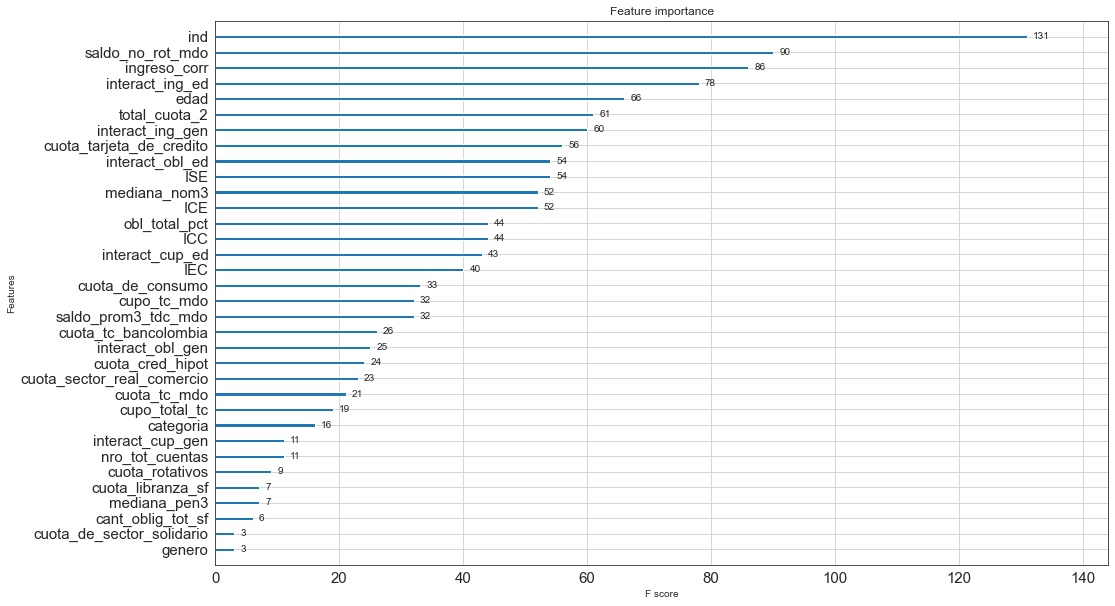

In [67]:
xgb.plot_importance(xgb_reg)

<AxesSubplot:xlabel='saldo_no_rot_mdo', ylabel='Density'>

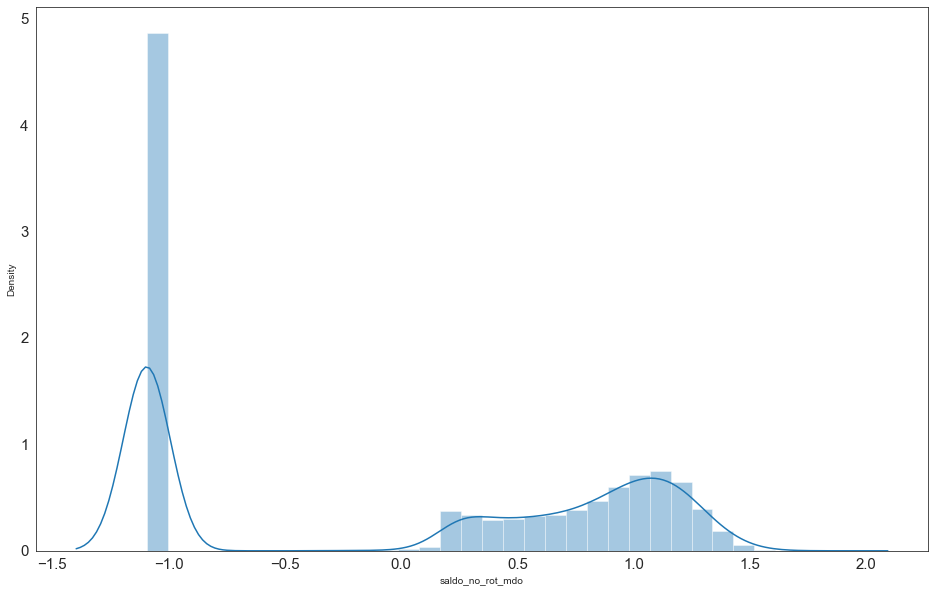

In [170]:
sns.distplot(X['saldo_no_rot_mdo'])

In [141]:
X

,genero,cupo_total_tc,cuota_tc_bancolombia,nro_tot_cuentas,cuota_cred_hipot,mediana_nom3,mediana_pen3,cuota_de_consumo,cuota_rotativos,cuota_tarjeta_de_credito,cuota_de_sector_solidario,cuota_sector_real_comercio,cupo_tc_mdo,saldo_prom3_tdc_mdo,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,ingreso_corr,obl_total_pct,interact_ing_gen,interact_ing_ed,interact_cup_gen,interact_cup_ed,interact_caida_ing,interact_caida_cuota,ICC,IEC,ICE,inflacion,ISE,mora_max_Entre 31 y 60 dias,mora_max_Mas de 60,mora_max_NApl,estado_civil_OTRO,estado_civil_SOL,estado_civil_UL,tipo_vivienda_OTRO,tipo_vivienda_PROPIA,ind_mora_vigente_S,cat_edad_M30_40,cat_edad_M40_50,cat_edad_M60,periodo_201903,periodo_201904,periodo_201905,periodo_201907,periodo_201908,periodo_201909,periodo_201910,periodo_201911,periodo_202001,periodo_202002,periodo_202003,periodo_202004,periodo_202005,periodo_202007,periodo_202008,periodo_202009,periodo_202010,periodo_202011
0,0,0.00000,0.00000,1,0.00000,59.41215,0.00000,39.76058,0.00000,0.00000,0.00000,0.00000,58.52885,57.89559,57.89559,65.16170,0.00000,4,59.41215,2.82045,0.00000,105.96810,0.00000,104.46247,0.00000,0.00000,-5.60000,-2.70000,-9.90000,3.01000,98.31513,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,64.38880,38.53215,1,0.00000,0.00000,0.00000,0.00000,0.00000,41.50544,0.00000,0.00000,52.43752,50.20186,31.46555,49.02984,0.00000,4,50.54649,5.44530,0.00000,86.05621,0.00000,113.01459,0.00000,0.00000,-5.60000,-2.70000,-9.90000,3.01000,98.31513,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0.00000,0.00000,1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,54.56969,0.00000,0.00000,99.82565,0.00000,0.00000,0.00000,0.00000,-5.60000,-2.70000,-9.90000,3.01000,98.31513,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0.00000,0.00000,1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,63.88349,0.00000,63.88349,122.71692,0.00000,0.00000,0.00000,0.00000,-5.60000,-2.70000,-9.90000,3.01000,98.31513,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0.00000,0.00000,1,0.00000,0.00000,0.00000,0.00000,0.00000,29.23948,0.00000,31.25810,41.05926,40.27955,33.85670,64.34820,0.00000,2,60.63622,1.74212,60.63622,104.86377,41.05926,72.42194,0.00000,0.00000,-5.60000,-2.70000,-9.90000,3.01000,98.31513,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94512,0,58.52885,37.11084,1,0.00000,0.00000,0.00000,0.00000,0.00000,38.59234,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2,49.83509,5.01347,0.00000,90.05133,0.00000,104.93306,0.00000,0.00000,-13.60000,6.50000,-43.90000,1.49000,114.59367,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
94513,1,0.00000,0.00000,1,0.00000,50.19644,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,26.12986,0.00000,0,55.80653,0.00000,55.80653,95.17833,0.00000,0.00000,0.00000,0.00000,-13.60000,6.50000,-43.90000,1.49000,114.59367,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
94514,0,0.00000,0.00000,1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,37.20011,0.00000,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-13.60000,6.50000,-43.90000,1.49000,114.59367,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
94515,1,0.00000,0.00000,1,0.00000,47.48663,0.00000,48.58424,0.00000,54.70024,0.00000,31.61704,62.61709,62.51097,62.51097,87.00771,0.00000,6,49.12276,8.95146,49.12276,89.98549,62.61709,113.36370,0.00000,0.00000,-13.60000,6.50000,-43.90000,1.49000,114.59367,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [388]:
fe_dataframe = DataFramePreProcessor(bc_dataframe,filter_threshold_l = 40000, filter_threshold_u = 30000000)
fe_dataframe.process()
clusters = fe_dataframe.modeling_dataframe['cluster'].unique().tolist()
for cluster in clusters:
    cluster_df = fe_dataframe.modeling_dataframe[fe_dataframe.modeling_dataframe['cluster'] == cluster]
    X =  cluster_df.drop(['log_gasto_familiar', 'periodo'], axis=1)              
    y = cluster_df['log_gasto_familiar']
    print("Porcentaje de filas: ",X.shape[0] / bc_dataframe.shape[0])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

    xgb_reg = xgb.XGBRegressor(objective='reg:squaredlogerror', 
                               n_estimators=80, 
                               max_depth=30, 
                               random_state=101,
                              colsample_bytree=0.5,
                              subsample=0.5,
                              min_child_weight=5)
    elastic_params ={'alpha': 0.010151733000510865, 'l1_ratio': 0.010077935175737287}
    elastic_reg = ElasticNet(**elastic_params)
    ridge_reg=Ridge()
    cat_reg = CatBoostRegressor(n_estimators=10)
    cat_reg.fit(X_train, y_train, verbose=False)

    ridge_reg.fit(X_train, y_train)
    xgb_reg.fit(X_train, y_train)
    elastic_reg.fit(X_train, y_train)
    # rf_reg.fit(X_train, y_train)
    xgb_pred = xgb_reg.predict(X_test)
    print("XGBoost: ", mean_absolute_percentage_error(xgb_pred, y_test))

    elastic_pred=elastic_reg.predict(X_test)
    print("Elastic Net: ", mean_absolute_percentage_error(elastic_pred, y_test))

    ridge_pred=ridge_reg.predict(X_test)
    print("Ridge: ", mean_absolute_percentage_error(ridge_pred, y_test))

    catboost_pred=cat_reg.predict(X_test)
    print("Catboost: ", mean_absolute_percentage_error(catboost_pred, y_test))  

    ensemble_predictions = xgb_pred*0.25 + elastic_pred*0.25  +ridge_pred*0.25 +catboost_pred*0.25
    print("Ensemble: ", mean_absolute_percentage_error(ensemble_predictions, y_test))
    the_predictions.append([xgb_reg,elastic_reg, ridge_reg, cat_reg])

Porcentaje de filas:  0.6643589376817813
XGBoost:  0.060046828170216865
Elastic Net:  0.06098543882352131
Ridge:  0.06097958578584909
Catboost:  0.06015065523128241
Ensemble:  0.06022954822316138
Porcentaje de filas:  0.026004863395794595
XGBoost:  0.059880078099526744
Elastic Net:  0.05759561256185758
Ridge:  0.05758145018523632
Catboost:  0.05920003232904074
Ensemble:  0.05777523577841725
Porcentaje de filas:  0.09298622037858198
XGBoost:  0.058336388710479664
Elastic Net:  0.05791681104557713
Ridge:  0.0579292316398129
Catboost:  0.05771796061612181
Ensemble:  0.05770970685547708
Porcentaje de filas:  0.007352310113002432
XGBoost:  0.3046954750070937
Elastic Net:  0.0610146460369061
Ridge:  0.061143094204708925
Catboost:  0.06264779638752112
Ensemble:  0.08625430567391353
Porcentaje de filas:  0.10995088923854479
XGBoost:  0.06188780886942999
Elastic Net:  0.060983221700443714
Ridge:  0.060997238274288386
Catboost:  0.06119140530990515
Ensemble:  0.061014664275655585


In [331]:
ranges =[
    [0, 200000],
    [50000, 100000],
    [200000, 500000],
    [500000, np.inf]
]

the_predictions = []
for r in ranges:
    
    fe_dataframe = DataFramePreProcessor(bc_dataframe,filter_threshold_l = r[0], filter_threshold_u = r[1])
    fe_dataframe.process()
    # modeling = fe_dataframe.modeling_dataframe[fe_dataframe.modeling_dataframe['total_cuota'] < -1.5]
    X = fe_dataframe.modeling_dataframe.drop(['log_gasto_familiar', 'periodo'], axis=1)
    y = fe_dataframe.modeling_dataframe['log_gasto_familiar']
    #scaled_data = scale(X) # promedio de los valores de cada gene debe ser cero con std 1
    #pca = PCA()
    #pca.fit(scaled_data )# Matemática del PCA
    #pca_data = pca.transform(scaled_data)
    print("Porcentaje de filas: ",X.shape[0] / bc_dataframe.shape[0])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

    xgb_reg = xgb.XGBRegressor(objective='reg:squaredlogerror', 
                               n_estimators=80, 
                               max_depth=30, 
                               random_state=101,
                              colsample_bytree=0.5,
                              subsample=0.5,
                              min_child_weight=5)
    elastic_params ={'alpha': 0.010151733000510865, 'l1_ratio': 0.010077935175737287}
    elastic_reg = ElasticNet(**elastic_params)
    #lasso_reg=Lasso()
    ridge_reg=Ridge()
    cat_reg = CatBoostRegressor(n_estimators=10)
    #rf_reg = RandomForestRegressor()
    cat_reg.fit(X_train, y_train, verbose=False)
    #model_lgb = lgb.LGBMRegressor(objective='regression')
    #model_lgb.fit(X_train, y_train)
    #lasso_reg.fit(X_train, y_train)
    ridge_reg.fit(X_train, y_train)
    xgb_reg.fit(X_train, y_train)
    elastic_reg.fit(X_train, y_train)
    # rf_reg.fit(X_train, y_train)
    xgb_pred = xgb_reg.predict(X_test)
    print("XGBoost: ", mean_absolute_percentage_error(xgb_pred, y_test))

    elastic_pred=elastic_reg.predict(X_test)
    print("Elastic Net: ", mean_absolute_percentage_error(elastic_pred, y_test))

    #lasso_pred= lasso_reg.predict(X_test)
    #print("Lasso: ", mean_absolute_percentage_error(lasso_pred, y_test))

    ridge_pred=ridge_reg.predict(X_test)
    print("Ridge: ", mean_absolute_percentage_error(ridge_pred, y_test))

    catboost_pred=cat_reg.predict(X_test)
    print("Catboost: ", mean_absolute_percentage_error(catboost_pred, y_test))  

    ensemble_predictions = xgb_pred*0.25 + elastic_pred*0.25  +ridge_pred*0.25 +catboost_pred*0.25
    print("Ensemble: ", mean_absolute_percentage_error(ensemble_predictions, y_test))
    the_predictions.append([xgb_reg,elastic_reg, ridge_reg, cat_reg])
    
fe_dataframe = DataFramePreProcessor(bc_dataframe,filter_threshold_l = 0, filter_threshold_u = np.inf)
fe_dataframe.process()
X = fe_dataframe.modeling_dataframe.drop(['log_gasto_familiar', 'periodo'], axis=1)
y = fe_dataframe.modeling_dataframe['log_gasto_familiar']
predictions_list = []
for model in the_predictions:
    final_predictions_xgb=np.expm1(model[0].predict(X))
    final_predictions_elastic=np.expm1(model[1].predict(X))
    final_predictions_ridge=np.expm1(model[2].predict(X))
    final_predictions_catboost=np.expm1(model[3].predict(X))

    final_prediction=final_predictions_xgb*0.25+final_predictions_elastic*0.25 + \
                       final_predictions_ridge*0.25 + final_predictions_catboost*0.25
    
    predictions_list.append(final_prediction)

Porcentaje de filas:  0.20857292709674344
XGBoost:  0.053623742310876674
Elastic Net:  0.05286344040612735
Ridge:  0.052863989408744295
Catboost:  0.052969038133898916
Ensemble:  0.05295468115461137
Porcentaje de filas:  0.04911076145520431
XGBoost:  0.01506793097776599
Elastic Net:  0.014990812702088787
Ridge:  0.014994846056741513
Catboost:  0.01504389332525491
Ensemble:  0.014992068930591795
Porcentaje de filas:  0.27363753397225005
XGBoost:  0.0181027053068748
Elastic Net:  0.01803531558328899
Ridge:  0.018037707407783737
Catboost:  0.018047507442397446
Ensemble:  0.018038323558960876
Porcentaje de filas:  0.44707004243551235
XGBoost:  0.03388821264924734
Elastic Net:  0.03448703557200597
Ridge:  0.034479773237196386
Catboost:  0.03399272126528693
Ensemble:  0.03402847630732747


In [360]:
0.447+0.274+0.05+0.21

0.9810000000000001

<AxesSubplot:xlabel='gasto_familiar', ylabel='Density'>

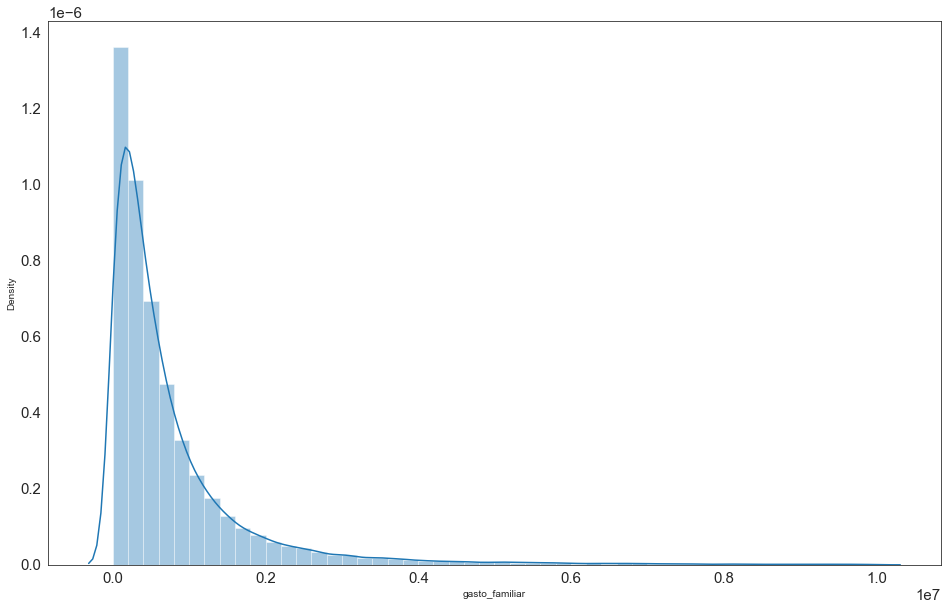

In [368]:
sns.distplot(bc_dataframe[bc_dataframe['gasto_familiar']<10000000]['gasto_familiar'])

In [369]:
bc_dataframe['gasto_familiar'].describe()

count      104865.00000
mean       857805.05544
std       2758171.97114
min             0.00000
25%        182530.00000
50%        434399.00000
75%        926148.40000
max     473728048.98000
Name: gasto_familiar, dtype: float64

In [372]:
from scipy import stats
stats.describe(aa)

DescribeResult(nobs=97449, minmax=(299329.1053294116, 1709539.0814466348), mean=404535.24985744536, variance=6259844058.789424, skewness=3.344654964091282, kurtosis=18.967285770441837)

<AxesSubplot:ylabel='Density'>

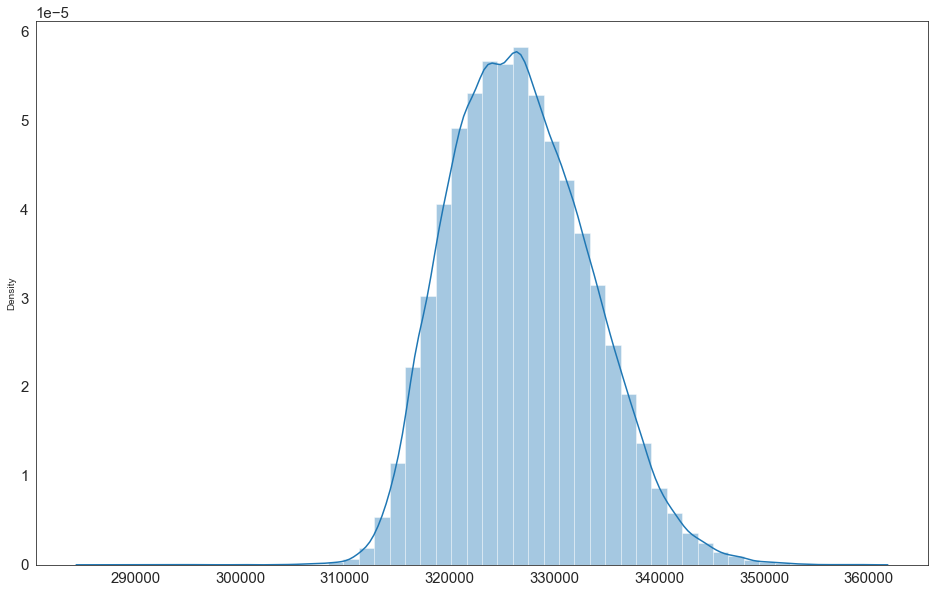

In [366]:
sns.distplot(predictions_list[2])

<AxesSubplot:ylabel='Density'>

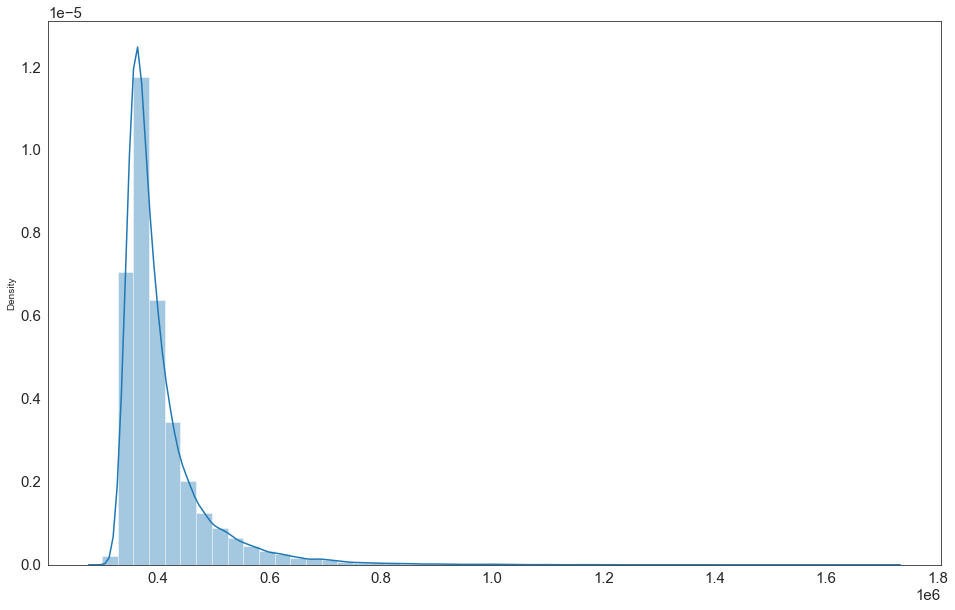

In [356]:
sns.distplot(np.mean(predictions_list, axis=0))

In [295]:
# BoxCox, Robust Scaler, Standard Scaler, Power Transformer
var= 'ind'
test_dataframe=bc_dataframe[(bc_dataframe[var] < np.quantile(bc_dataframe[var], 0.999)) |
                           (bc_dataframe[var] >= 0) ]

transformer = PowerTransformer()
sscaler = StandardScaler()
rscaler = RobustScaler()
rs_transformed = rscaler.fit_transform(test_dataframe[var].values.reshape(-1,1))
ss_transformed = sscaler.fit_transform(test_dataframe[var].values.reshape(-1,1))
boxcox_transformed= boxcox1p(test_dataframe[var], 0.05)
PT_transformed =  transformer.fit_transform(test_dataframe[var].values.reshape(-1,1))

In [72]:
fe_dataframe.modeling_dataframe

,periodo,edad,cupo_total_tc,cuota_tc_bancolombia,cuota_cred_hipot,cuota_de_consumo,cuota_rotativos,cuota_tarjeta_de_credito,cuota_de_sector_solidario,cuota_sector_real_comercio,cupo_tc_mdo,cuota_tc_mdo,cuota_libranza_sf,educacion_grupo,ingreso_corr,obl_total_pct,interact_ing_gen,interact_ing_ed,interact_cup_gen,interact_cup_ed,total_cuota_2,cuota_cred_hipot_2,log_gasto_familiar,mora_max_Entre 31 y 60 dias,mora_max_Mas de 60,mora_max_NApl,estado_civil_DIV,estado_civil_OTRO,estado_civil_SOL,estado_civil_UL,estado_civil_VIU,tipo_vivienda_FAMILIAR,tipo_vivienda_OTRO,tipo_vivienda_PROPIA,nivel_academico_ESPECIALIZACION,nivel_academico_NINGUNO,nivel_academico_NO INFORMA,nivel_academico_PRIMARIO,nivel_academico_SIN INFORMACION,nivel_academico_TECNOLOGO,nivel_academico_UNIVERSITARIO
0,201902,55,-0.79794,-0.79785,-0.40989,-0.82240,-0.34144,-1.07996,-0.27640,-0.57292,-0.96656,-0.72835,-0.26504,1,-0.29217,-1.40369,-0.98069,0.02930,-0.70496,-1.34516,-1.54475,-0.40989,14.07610,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,201902,24,1.20037,1.20894,-0.40989,1.17456,-0.34144,0.47782,-0.27640,-0.57292,-0.96656,-0.72835,-0.26504,0,-1.15110,0.69438,0.87363,-1.39405,1.37933,0.37064,0.27997,-0.40989,10.82777,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
2,201902,71,1.38165,1.33962,-0.40989,1.28505,-0.34144,1.20960,-0.27640,-0.57292,1.27543,-0.72835,-0.26504,1,3.49082,-0.26457,1.35328,4.01366,1.50974,1.48584,1.20180,-0.40989,13.98840,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
3,201902,59,-0.79794,-0.79785,2.43989,1.30337,-0.34144,0.58633,-0.27640,-0.57292,0.89231,1.28211,-0.26504,1,-0.15682,1.15595,-0.98069,0.22613,-0.70496,0.48251,0.85729,2.43989,14.54116,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
4,201902,41,1.18049,1.25248,-0.40989,1.26919,-0.34144,1.01867,-0.27640,-0.57292,0.95426,1.43053,-0.26504,1,0.39117,0.64149,-0.98069,0.38496,-0.70496,0.60861,0.85957,-0.40989,13.87030,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5458,202011,34,-0.79794,-0.79785,-0.40989,1.21457,-0.34144,1.04474,-0.27640,-0.57292,1.01808,1.45416,-0.26504,0,-0.82367,1.16600,-0.98069,-0.86493,-0.70496,0.59469,0.74023,-0.40989,12.66560,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
5459,202011,29,-0.79794,-0.79785,-0.40989,-0.82240,-0.34144,-1.07996,-0.27640,-0.57292,-0.96656,-0.72835,-0.26504,0,-0.81956,-1.40369,-0.98069,-0.98060,-0.70496,-1.34516,-1.54475,-0.40989,12.44896,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
5460,202011,42,1.26502,1.27554,-0.40989,1.23727,-0.34144,1.10576,-0.27640,-0.57292,1.06600,1.40658,-0.26504,1,0.01687,0.83017,-0.98069,0.06838,-0.70496,0.85472,0.92221,-0.40989,13.27062,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
5461,202011,50,-0.79794,-0.79785,-0.40989,1.19316,-0.34144,0.81821,3.61799,-0.57292,1.07907,1.31636,-0.26504,0,0.77680,-0.01191,-0.98069,0.94549,-0.70496,0.79022,0.46668,-0.40989,13.47023,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


count   94275.00000
mean       -0.00000
std         1.00001
min        -0.79785
25%        -0.79785
50%        -0.79785
75%         1.22568
max         1.49980
Name: cuota_tc_bancolombia, dtype: float64


<AxesSubplot:xlabel='cuota_tc_bancolombia', ylabel='Density'>

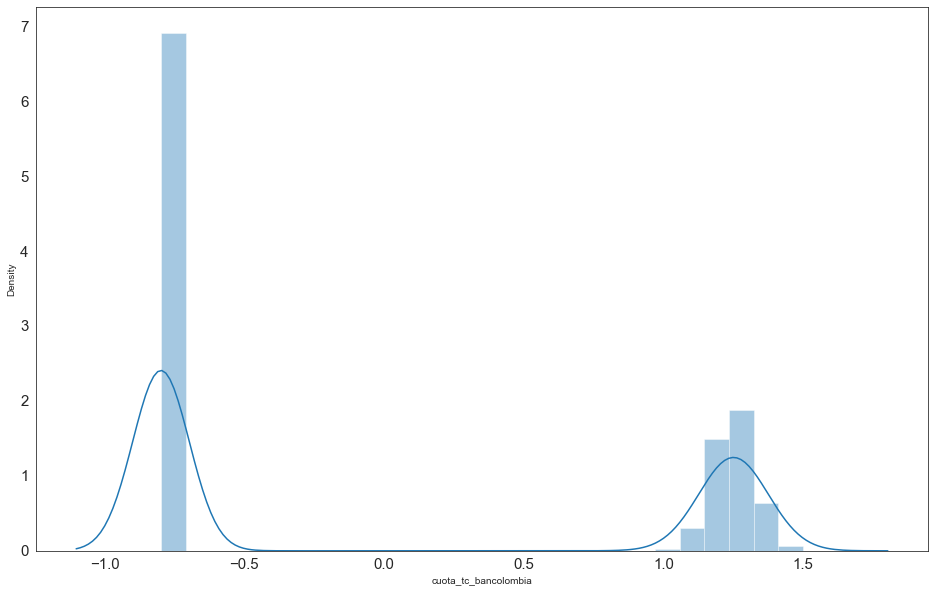

In [75]:
var = 'cuota_tc_bancolombia'
print(fe_dataframe.modeling_dataframe[var].describe())
sns.distplot(fe_dataframe.modeling_dataframe[var])

In [133]:
fe_dataframe = DataFramePreProcessor(bc_dataframe)
fe_dataframe.process()

,periodo,edad,cupo_total_tc,cuota_tc_bancolombia,nro_tot_cuentas,cuota_cred_hipot,mediana_nom3,mediana_pen3,cuota_de_consumo,cuota_rotativos,cuota_tarjeta_de_credito,cuota_de_sector_solidario,cuota_sector_real_comercio,cupo_tc_mdo,saldo_prom3_tdc_mdo,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,gasto_familiar,educacion_grupo,ingreso_corr,obl_total_pct,total_cuota,total_cupo,interact_ing_gen,interact_ing_ed,interact_cup_gen,interact_cup_ed,total_cuota_2,cuota_cred_hipot_2,log_gasto_familiar,mora_max_Entre 31 y 60 dias,mora_max_Mas de 60,mora_max_NApl,estado_civil_DIV,estado_civil_OTRO,estado_civil_SOL,estado_civil_UL,estado_civil_VIU,tipo_vivienda_FAMILIAR,tipo_vivienda_OTRO,tipo_vivienda_PROPIA,nivel_academico_ESPECIALIZACION,nivel_academico_NINGUNO,nivel_academico_NO INFORMA,nivel_academico_PRIMARIO,nivel_academico_SIN INFORMACION,nivel_academico_TECNOLOGO,nivel_academico_UNIVERSITARIO
0,201902,42,-0.79244,-0.79235,1,-0.40859,1.37827,-0.24574,1.31998,-0.33488,0.91737,-0.27971,-0.57244,1.13817,1.35667,1.34884,1.12736,-0.26510,8,460328.00000,0,-0.23575,1.21696,0.91432,0.89183,-0.98771,-0.16060,-0.70943,0.87651,0.91432,-0.40859,13.03970,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,201902,69,-0.79244,-0.79235,1,-0.40859,-0.72882,4.06930,-0.82036,-0.33488,0.78852,3.57516,-0.57244,1.05521,1.11798,1.36414,-1.10127,-0.26510,2,192870.00000,1,-0.24259,0.05565,0.25077,0.69708,-0.98771,0.29322,-0.70943,0.81984,0.25077,-0.40859,12.16978,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,201902,41,1.19193,1.22736,1,-0.40859,-0.72882,-0.24574,1.24043,-0.33488,0.58413,-0.27971,-0.57244,-0.96855,-0.78892,-0.73165,1.10902,-0.26510,2,1031376.00000,1,-1.04639,1.07038,0.49867,0.35416,-0.98771,-0.92413,-0.70943,0.41711,0.49867,-0.40859,13.84641,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,201902,63,-0.79244,-0.79235,2,-0.40859,-0.72882,4.06930,1.11676,2.98663,0.82594,-0.27971,-0.57244,1.08317,1.16214,1.32871,0.84725,3.77223,5,561502.00000,1,0.40716,0.06083,0.48660,0.76088,-0.98771,0.84541,-0.70943,0.85545,0.48660,-0.40859,13.23837,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
5,201902,71,-0.79244,-0.79235,1,-0.40859,-0.72882,4.06930,1.26670,-0.33488,-1.08186,-0.27971,-0.57244,-0.96855,-0.78892,-0.73165,1.19960,3.77223,1,455483.00000,0,-0.97789,1.18323,0.77964,-1.33817,0.88902,-0.42558,-0.70943,-1.34468,0.77964,-0.40859,13.02912,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5585,202011,51,-0.79244,-0.79235,1,-0.40859,-0.72882,-0.24574,-0.82036,-0.33488,-1.08186,-0.27971,-0.57244,-0.96855,-0.78892,-0.73165,-1.10127,-0.26510,0,675020.00000,1,-0.55924,-1.40683,-1.54396,-1.33817,-0.98771,-0.29328,-0.70943,-1.34468,-1.54396,-0.40859,13.42250,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
5586,202011,36,-0.79244,-0.79235,1,-0.40859,-0.72882,-0.24574,-0.82036,-0.33488,1.07099,-0.27971,-0.57244,1.26650,1.37470,1.45290,-1.10127,-0.26510,4,781750.00000,1,0.27920,0.26405,0.66345,1.22784,1.05859,0.16135,1.48234,1.11624,0.66345,-0.40859,13.56929,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
5587,202011,34,-0.79244,-0.79235,1,-0.40859,1.37030,-0.24574,-0.82036,-0.33488,-1.08186,-0.27971,-0.57244,-0.96855,-0.78892,-0.73165,-1.10127,-0.26510,0,706034.00000,0,0.18016,-1.40683,-1.54396,-1.33817,1.04682,0.02093,-0.70943,-1.34468,-1.54396,-0.40859,13.46742,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
5588,202011,47,-0.79244,-0.79235,1,-0.40859,-0.72882,-0.24574,-0.82036,-0.33488,-1.08186,-0.27971,-0.57244,-0.96855,-0.78892,-0.73165,-1.10127,-0.26510,0,602310.00000,1,-4.81713,-1.40683,-1.54396,-1.33817,-0.98771,-4.70297,-0.70943,-1.34468,-1.54396,-0.40859,13.30853,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


cluster
4    728156.24743
1    801240.01276
2    936851.21324
3   1024456.76364
0   1251691.33515
Name: gasto_familiar, dtype: float64
2    34546
4    25117
1    23594
0    10571
3     3292
Name: cluster, dtype: int64


<AxesSubplot:xlabel='cluster', ylabel='total_cuota'>

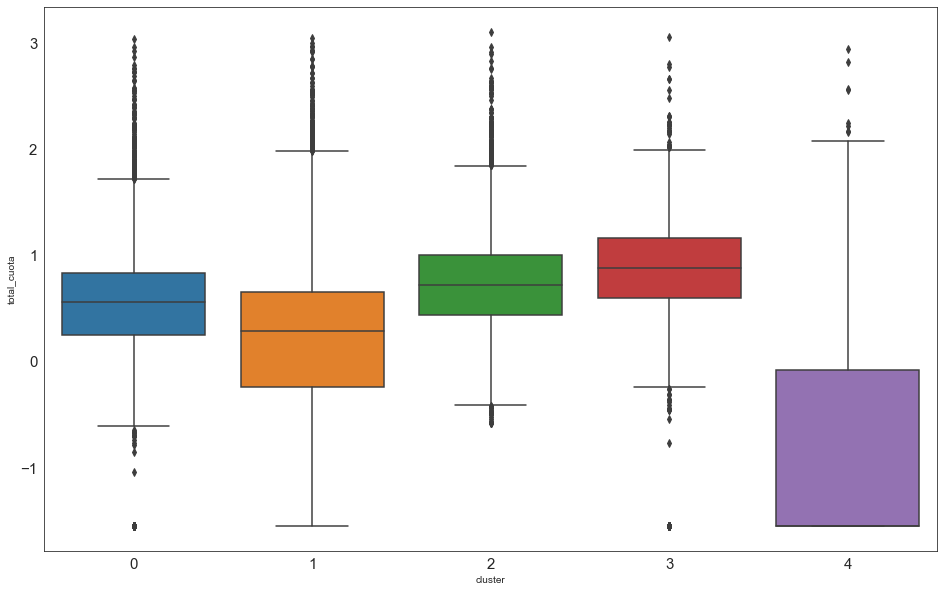

In [134]:

variables = [
    'cuota_cred_hipot',
    'cuota_tarjeta_de_credito',
    'cuota_de_consumo',
    'cuota_rotativos',
    'cuota_sector_real_comercio',
    'cuota_de_sector_solidario',
    'cuota_tc_bancolombia',
    'cuota_libranza_sf',
    "gasto_familiar",
    "ingreso_corr",
    "cupo_tc_mdo",
    "nro_tot_cuentas",
    "mediana_nom3",
    "mediana_pen3",
    "cant_oblig_tot_sf",
    "saldo_prom3_tdc_mdo",
    "cupo_total_tc",
    "saldo_no_rot_mdo"
]

gm = GaussianMixture(n_components=5, random_state=1).fit_predict(fe_dataframe.modeling_dataframe[variables])
fe_dataframe.modeling_dataframe['cluster'] = gm
#fe_dataframe.modeling_dataframe[variables]['cluster'] = fe_dataframe.modeling_dataframe[variables]['cluster'].astype(str)
print(gm_data.groupby('cluster')['gasto_familiar'].mean().sort_values())
print(gm_data['cluster'].value_counts())
sns.boxplot(data=fe_dataframe.modeling_dataframe, x='cluster', y='total_cupo')

<AxesSubplot:xlabel='ind', ylabel='Density'>

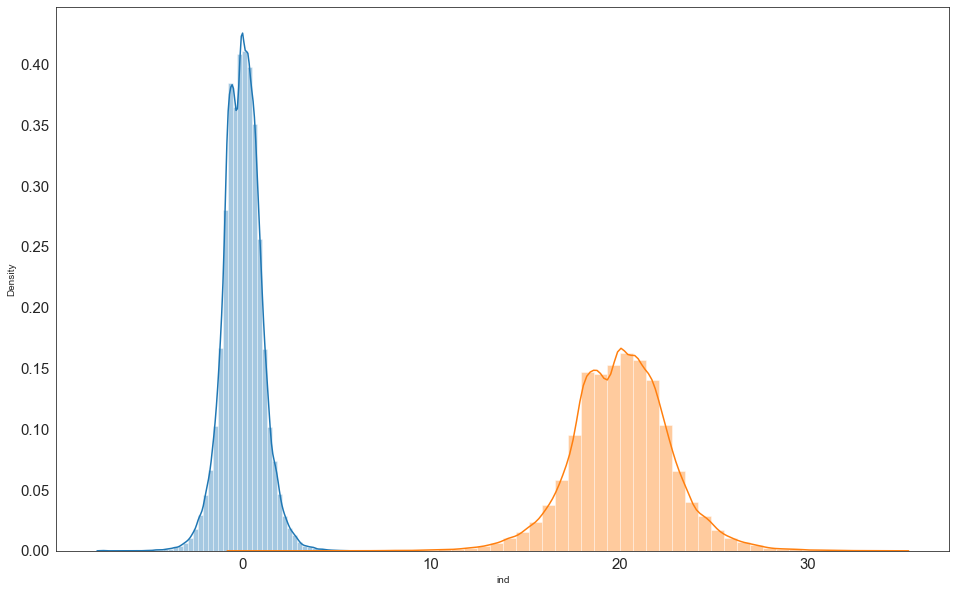

In [37]:
#sns.distplot(test_dataframe['ind'])
sns.distplot(PT_transformed)
sns.distplot(boxcox_transformed)
#sns.distplot(ss_transformed)
#sns.distplot(rs_transformed)

#plt.legend(['Power Transformer', " Box-Cox", " Standard Scaler", "Robust Scaler"])

In [ ]:
lightgbm_reg = create_model('lightgbm')
xgboost_reg = create_model('xgboost')
catboost_reg = create_model('catboost')


In [ ]:
predict_model(blender, data=X_test)


In [182]:
exp_reg = setup(fe_dataframe.modeling_dataframe.drop(["periodo"], axis=1),
                target = 'log_gasto_familiar', polynomial_features=True,
                html=False,
                verbose=False,
               silent=True)
lightgbm_reg = create_model('lightgbm')
lgbm_preds =  np.expm1(predict_model(lightgbm_reg, data=X_test)['Label'])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.76250,0.91590,0.95700,0.14810,0.06780,0.05860
1,0.75910,0.91690,0.95750,0.14050,0.06780,0.05840
2,0.77160,0.95480,0.97710,0.14870,0.06900,0.05910
3,0.76660,0.94170,0.97040,0.12970,0.06840,0.05860
4,0.76380,0.92290,0.96070,0.15650,0.06800,0.05870
5,0.75410,0.90570,0.95170,0.15120,0.06730,0.05780
6,0.76000,0.91770,0.95800,0.14380,0.06780,0.05840
7,0.75390,0.91220,0.95510,0.15050,0.06750,0.05790
8,0.75810,0.90600,0.95190,0.15340,0.06750,0.05830
9,0.76300,0.93190,0.96530,0.15870,0.06850,0.05880


In [130]:
X['total_cuota'].value_counts()

Series([], Name: total_cuota, dtype: int64)

In [501]:
X.corr().to_csv("correlations.csv")

In [ ]:
X.columns.sort_values()

# Ensemble Pipeline

In [14]:
print(f"Hora de inicio: {datetime.now()}")
dates = [
    '201902', '201903', '201904', '201905', '201907', '201908', '201909',
    '201910', '201911', '202001', '202002', '202003', '202004', '202005',
    '202007', '202008', '202009', '202010', '202011'
]

test_df = pd.read_csv("test_cleaned.csv")
test_df_modeling = DataFramePreProcessor(test_df, test=True)
test_df_modeling.process()

last_predictions_list = []
y_tests = []
x_tests = []
y_preds = []
mapes   = []
models = []
p = 0.002

callback = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
optimizer   = Adam(learning_rate=0.003)
nn_metric = MeanAbsolutePercentageError(name='mape') 

random.seed(1234)

for date in dates:
    print(f"Periodo {date}:")
    raw_dataframe = pd.read_csv(
             f"train_{date}_cleaned.csv",
             header=0,
             skiprows=lambda i: i>0 and random.random() > p
    ).drop("Unnamed: 0", axis=1)
    print(f"     Total rows in original_data {raw_dataframe.shape[0]}" )
    fe_dataframe = DataFramePreProcessor(raw_dataframe)
    fe_dataframe.process()
    X = fe_dataframe.modeling_dataframe.drop([ "log_gasto_familiar",
                                         "periodo"], axis=1)
    y = fe_dataframe.modeling_dataframe['log_gasto_familiar']
    print(f"     Total rows in transformed_data {fe_dataframe.modeling_dataframe.shape[0]}" )
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

    nn_model = Sequential()
    
    nn_model.add(Dense(128, activation = 'relu', input_shape = (X.shape[1],))) 
    nn_model.add(Dropout(0.2))
    #nn_model.add(Dense(100, activation = 'tanh'))
    nn_model.add(BatchNormalization())
    nn_model.add(Dense(64, activation = 'tanh'))
    nn_model.add(Dropout(0.2))
    #nn_model.add(Dense(25, activation = 'relu'))
    nn_model.add(Dense(1))
    nn_model.compile(optimizer =  optimizer, loss = 'mse', metrics = nn_metric)
    history  = nn_model.fit(X_train, y_train, epochs=20, callbacks=[callback], validation_split = 0.2)
    
    
    models.append(nn_model)

    nn_pred = nn_model.predict(X_test).reshape(-1,)
    y_tests.append(y_test)
    x_tests.append(X_test)

    mape = mean_absolute_percentage_error(nn_pred, y_test)
    mapes.append(mape)
    print(f"     MAPE {date}: ", mape )

    #last_predictions_list.append(submission)
print(f"Hora de finalizacion: {datetime.now()}")

Hora de inicio: 2021-01-26 23:20:26.167797
Periodo 201902:
     Total rows in original_data 2047
     Total rows in transformed_data 1645
Epoch 1/20
33/33 [==============================] - 1s 11ms/step - loss: 156.8961 - mape: 94.7997 - val_loss: 110.0678 - val_mape: 79.0143
Epoch 2/20
33/33 [==============================] - 0s 4ms/step - loss: 61.9232 - mape: 53.8293 - val_loss: 6.0410 - val_mape: 14.1249
Epoch 3/20
33/33 [==============================] - 0s 4ms/step - loss: 9.1541 - mape: 18.8567 - val_loss: 2.4497 - val_mape: 9.5086
Epoch 4/20
33/33 [==============================] - 0s 4ms/step - loss: 6.1884 - mape: 14.8607 - val_loss: 1.8150 - val_mape: 8.9454
Epoch 5/20
33/33 [==============================] - 0s 4ms/step - loss: 5.9026 - mape: 15.0666 - val_loss: 1.5274 - val_mape: 8.1951
Epoch 6/20
33/33 [==============================] - 0s 4ms/step - loss: 5.2157 - mape: 14.1755 - val_loss: 1.4539 - val_mape: 7.9696
Epoch 7/20
33/33 [==============================] - 0s 4

40/40 [==============================] - 0s 5ms/step - loss: 3.0904 - mape: 10.8700 - val_loss: 1.3502 - val_mape: 7.0433
     MAPE 201908:  0.06376284078406724
Periodo 201909:
     Total rows in original_data 2311
     Total rows in transformed_data 2088
Epoch 1/20
42/42 [==============================] - 1s 10ms/step - loss: 90.6553 - mape: 36.7594 - val_loss: 10.7097 - val_mape: 14.3051
Epoch 2/20
42/42 [==============================] - 0s 4ms/step - loss: 5.3159 - mape: 14.2547 - val_loss: 1.4601 - val_mape: 6.7262
Epoch 3/20
42/42 [==============================] - 0s 6ms/step - loss: 4.3107 - mape: 12.7468 - val_loss: 0.9549 - val_mape: 6.1937
Epoch 4/20
42/42 [==============================] - 0s 5ms/step - loss: 3.8557 - mape: 11.9427 - val_loss: 0.9469 - val_mape: 6.2223
Epoch 5/20
42/42 [==============================] - 0s 4ms/step - loss: 3.9209 - mape: 12.2617 - val_loss: 0.9463 - val_mape: 6.1478
Epoch 6/20
42/42 [==============================] - 0s 4ms/step - loss: 3.7

42/42 [==============================] - 0s 4ms/step - loss: 3.3216 - mape: 10.6972 - val_loss: 1.2279 - val_mape: 6.4592
Epoch 17/20
42/42 [==============================] - 0s 8ms/step - loss: 3.2120 - mape: 10.8095 - val_loss: 1.0109 - val_mape: 6.1787
Epoch 18/20
42/42 [==============================] - 0s 5ms/step - loss: 3.4178 - mape: 11.1362 - val_loss: 1.0034 - val_mape: 6.0052
Epoch 19/20
42/42 [==============================] - 0s 4ms/step - loss: 3.0018 - mape: 10.6093 - val_loss: 0.9973 - val_mape: 6.1091
Epoch 20/20
42/42 [==============================] - 0s 4ms/step - loss: 3.5759 - mape: 11.6455 - val_loss: 0.9821 - val_mape: 6.0038
     MAPE 202003:  0.05845564676962806
Periodo 202004:
     Total rows in original_data 2201
     Total rows in transformed_data 1867
Epoch 1/20
38/38 [==============================] - 1s 14ms/step - loss: 92.4782 - mape: 35.9075 - val_loss: 9.2604 - val_mape: 17.9769
Epoch 2/20
38/38 [==============================] - 0s 5ms/step - loss: 

42/42 [==============================] - 0s 4ms/step - loss: 3.5108 - mape: 11.4004 - val_loss: 1.2591 - val_mape: 6.4476
Epoch 13/20
42/42 [==============================] - 0s 4ms/step - loss: 3.5076 - mape: 11.2232 - val_loss: 1.5936 - val_mape: 7.2634
Epoch 14/20
42/42 [==============================] - 0s 5ms/step - loss: 3.7656 - mape: 11.5922 - val_loss: 1.1652 - val_mape: 6.1321
Epoch 15/20
42/42 [==============================] - 0s 4ms/step - loss: 3.9049 - mape: 11.8195 - val_loss: 1.5793 - val_mape: 7.0979
Epoch 16/20
42/42 [==============================] - 0s 4ms/step - loss: 3.4511 - mape: 11.1631 - val_loss: 1.4552 - val_mape: 6.6852
Epoch 17/20
42/42 [==============================] - 0s 4ms/step - loss: 3.6820 - mape: 11.5203 - val_loss: 1.3567 - val_mape: 6.3759
Epoch 18/20
42/42 [==============================] - 0s 4ms/step - loss: 3.3889 - mape: 11.0991 - val_loss: 1.2414 - val_mape: 6.0818
Epoch 19/20
42/42 [==============================] - 0s 3ms/step - loss: 3

In [15]:
np.mean(mapes)

0.06496028901314739

In [16]:
predictions_df = test_df_modeling.modeling_dataframe.drop(["id_registro", "periodo"], axis=1)

nn_stack_predictions = []
for model in models:
    nn_stack_predictions.append(model.predict(predictions_df).reshape(-1,))

In [17]:
nn_stack = np.expm1(np.mean(nn_stack_predictions, axis=0))
nn_stack

array([433936.03, 426143.56, 432057.56, ..., 434439.97, 433868.6 ,
       435281.84], dtype=float32)

In [18]:
submission = pd.concat([test_df['id_registro'],pd.Series(nn_stack)], axis=1)
submission.columns = ["id_registro", "gasto_familiar"]
submission['gasto_familiar'] = submission['gasto_familiar'].round(4)
submission

,id_registro,gasto_familiar
0,4055#201902,433936.03125
1,12598#201902,426143.56250
2,23697#201902,432057.56250
3,23768#201902,422005.46875
4,7174#201902,435170.18750
...,...,...
281661,8596193#202011,427407.75000
281662,8616083#202011,433172.78125
281663,8670207#202011,434440.00000
281664,8677655#202011,433868.59375


In [21]:
submission.to_csv("submission_underground_nn.csv", index=False)

In [22]:
submission['gasto_familiar'].describe()

count   281666.00000
mean    425034.71875
std      26076.90820
min         59.81820
25%     425868.93750
50%     430122.03125
75%     432942.34375
max     438897.09375
Name: gasto_familiar, dtype: float64

# Ranking models

In [23]:
all_mapes = []
for model in models:
    mape_model = []
    for x_test, y_test in zip(x_tests, y_tests):
        nn_prediction_ = model.predict(x_test).reshape(-1,)
        mape_model.append(mean_absolute_percentage_error(nn_prediction_, y_test))
    all_mapes.append(np.mean(mape_model))

In [24]:
all_mapes

[0.0628316444383105,
 0.06236099250046525,
 0.06254469034726311,
 0.062005257494711585,
 0.06243575649703442,
 0.06215497452470366,
 0.0625051131421925,
 0.06306848363191897,
 0.06237709180787773,
 0.062299382896610064,
 0.0625401373840554,
 0.06243541837033755,
 0.06294635191042477,
 0.06313317125211804,
 0.06351331581662505,
 0.06335375869325528,
 0.062231182135330056,
 0.06275958607868888,
 0.06677721127864338]

In [31]:
best_mapes = sorted(range(len(all_mapes)), key=lambda i: all_mapes[i], reverse=False)[:5]
predictions_df = test_df_modeling.modeling_dataframe.drop(["id_registro", "periodo"], axis=1)
nn_stack_predictions = []
for i in best_mapes:
    nn_stack_predictions.append(models[i].predict(predictions_df).reshape(-1,))
nn_stack = np.expm1(np.mean(nn_stack_predictions, axis=0))
nn_stack

array([ 419128.9 ,  312964.94,  515340.97, ..., 1211003.6 ,  810337.56,
        732499.3 ], dtype=float32)

# PyCaret Pipeline

In [ ]:
print(f"Hora de inicio: {datetime.now()}")
dates = [
    '201902', '201903', '201904', '201905', '201907', '201908', '201909',
    '201910', '201911', '202001', '202002', '202003', '202004', '202005',
    '202007', '202008', '202009', '202010', '202011'
]

test_df = pd.read_csv("test_cleaned.csv")
test_df['cuota_de_consumo'] = np.where(test_df['cuota_de_consumo'] <0 ,0, test_df['cuota_de_consumo'])
test_df_modeling = DataFramePreProcessor(test_df, test=True)
test_df_modeling.process()

last_predictions_list = []
p = 0.015
random.seed(800)
seeds = [5555, 498, 316, 825, 89]
models_pycaret =[]
for i,seed in enumerate(seeds):
    print(f"Iteracion {i+1}:")
    random.seed(seed)
    raw_dataframe = []
    for date in dates:
        df = pd.read_csv(
                 f"train_{date}_cleaned.csv",
                 header=0,
                 skiprows=lambda i: i>0 and random.random() > p
        ).drop("Unnamed: 0", axis=1)
        raw_dataframe.append(df)
    raw_dataframe = pd.concat(raw_dataframe, axis=0)
    print(f"     Total rows in original_data {raw_dataframe.shape[0]}" )

    fe_dataframe = DataFramePreProcessor(raw_dataframe)
    fe_dataframe.process()
    print(f"     Total rows in transformed_data {fe_dataframe.modeling_dataframe.shape[0]}" )

    exp_reg = setup(fe_dataframe.modeling_dataframe.drop(["periodo"], axis=1),
                target = 'log_gasto_familiar', polynomial_features=True,
                html=False,
                verbose=False,
               silent=True)
    lightgbm_reg = create_model('lightgbm')
    models_pycaret.append(lightgbm_reg)
    
    predictions_df = test_df_modeling.modeling_dataframe.drop(["periodo","id_registro"], axis=1)
    final_prediction=  np.expm1(predict_model(lightgbm_reg, data=predictions_df)['Label'])
    
    submission = pd.concat([month_test['id_registro'],pd.Series(final_prediction)], axis=1)
    submission.columns = ["id_registro", "gasto_familiar"]
    submission['gasto_familiar'] = submission['gasto_familiar'].round(4)
    #submission['gasto_familiar'] = np.where(submission['gasto_familiar'] > 10000000, 10000000, submission['gasto_familiar'])
    
    last_predictions_list.append(submission)
print(f"Hora de finalizacion: {datetime.now()}")

# Ensemble Mixed months

In [68]:
print(f"Hora de inicio: {datetime.now()}")
dates = [
    '201902', '201903', '201904', '201905', '201907', '201908', '201909',
    '201910', '201911', '202001', '202002', '202003', '202004', '202005',
    '202007', '202008', '202009', '202010', '202011'
]

test_df = pd.read_csv("test_cleaned.csv")
test_df['cuota_de_consumo'] = np.where(test_df['cuota_de_consumo'] <0 ,0, test_df['cuota_de_consumo'])
test_df_modeling = DataFramePreProcessor(test_df, test=True)
test_df_modeling.process()

models = []
mapes= []
p = 0.001
seeds = [5555, 498, 316, 825, 89]
with open('tuned_hyper_parameters.json') as f:
    tuned_hyperparameters = json.load(f)
    
for i,seed in enumerate(seeds):
    print(f"Iteracion {i+1}:")
    random.seed(seed)
    raw_dataframe = []
    for date in dates:
        df = pd.read_csv(
                 f"train_{date}_cleaned.csv",
                 header=0,
                 skiprows=lambda i: i>0 and random.random() > p
        ).drop("Unnamed: 0", axis=1)
        raw_dataframe.append(df)
    raw_dataframe = pd.concat(raw_dataframe, axis=0)
    print(f"     Total rows in original_data {raw_dataframe.shape[0]}" )
    
    fe_dataframe = DataFramePreProcessor(raw_dataframe)
    fe_dataframe.process()
    print(f"     Total rows in transformed_data {fe_dataframe.modeling_dataframe.shape[0]}" )
    
    X = fe_dataframe.modeling_dataframe.drop([ "log_gasto_familiar",
                                         "periodo"], axis=1)
    y = fe_dataframe.modeling_dataframe['log_gasto_familiar']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
    
    xgb_reg = xgb.XGBRegressor(**tuned_hyperparameters['xgb'])
    cat_reg = CatBoostRegressor(**tuned_hyperparameters['catboost']) 
    
    xgb_reg.fit(X_train, y_train)
    cat_reg.fit(X_train, y_train, verbose=False)
    
    models.append([xgb_reg, cat_reg])
    xgb_pred = xgb_reg.predict(X_test)
    catboost_pred = cat_reg.predict(X_test)
    ensemble_prediction=xgb_pred*0.5 +  +catboost_pred*0.5
    mape = mean_absolute_percentage_error(ensemble_prediction, y_test)
    mapes.append(mape)
    print(f"     MAPE {date}: ", mape )
    
print(f"Hora de finalizacion: {datetime.now()}")

Hora de inicio: 2021-01-29 12:25:34.682853
Iteracion 1:
     Total rows in original_data 21006
     Total rows in transformed_data 17418
     MAPE 202011:  0.05369101281649906
Iteracion 2:
     Total rows in original_data 20886
     Total rows in transformed_data 17399
     MAPE 202011:  0.05488257541065851
Iteracion 3:
     Total rows in original_data 20788
     Total rows in transformed_data 17250
     MAPE 202011:  0.054152211642877784
Iteracion 4:
     Total rows in original_data 21238
     Total rows in transformed_data 17691
     MAPE 202011:  0.054567124925904646
Iteracion 5:
     Total rows in original_data 21129
     Total rows in transformed_data 17758
     MAPE 202011:  0.053124637822179015
Hora de finalizacion: 2021-01-29 12:30:26.505292


In [64]:
X

,genero,categoria,cupo_total_tc,cuota_tc_bancolombia,nro_tot_cuentas,cuota_cred_hipot,mediana_nom3,mediana_pen3,cuota_de_consumo,cuota_rotativos,cuota_tarjeta_de_credito,cuota_de_sector_solidario,cuota_sector_real_comercio,cupo_tc_mdo,saldo_prom3_tdc_mdo,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,ingreso_corr,obl_total_pct,total_cuota_2,ICC,IEC,ICE,ISE
0,0,1,0.00000,0.00000,1,0.00000,2163.74514,0.00000,1046.81076,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3117.61600,0.00000,1,2163.74514,7.88978,549998.00000,0.71293,0.57226,0.74320,0.36647
1,0,4,0.00000,0.00000,1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,3049.22992,0.00000,0.00000,0.71293,0.57226,0.74320,0.36647
2,0,1,0.00000,0.00000,0,0.00000,2341.85665,0.00000,0.00000,0.00000,0.00000,0.00000,1445.75827,0.00000,0.00000,0.00000,3148.23872,0.00000,0,2341.85665,10.51448,0.00000,0.71293,0.57226,0.74320,0.36647
3,0,1,0.00000,0.00000,1,0.00000,2362.02707,0.00000,0.00000,0.00000,0.00000,0.00000,1191.31639,2736.61352,2369.91990,772.59925,7749.90325,0.00000,1,2362.02707,8.29181,0.00000,0.71293,0.57226,0.74320,0.36647
4,0,2,5155.51917,1356.20114,1,0.00000,0.00000,0.00000,3423.78517,0.00000,4118.19466,0.00000,1071.31449,9155.94759,3559.46094,5674.26673,9212.11982,0.00000,7,6728.79371,14.85130,23766351.16500,0.71293,0.57226,0.74320,0.36647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609890,1,1,1262.91265,286.45104,1,0.00000,0.00000,0.00000,0.00000,0.00000,412.73365,0.00000,0.00000,2095.61865,0.00000,0.00000,0.00000,0.00000,2,2118.37827,3.16765,213598.00001,0.57042,0.82843,0.37186,0.68686
2609891,1,2,8600.32550,1214.55415,1,0.00000,0.00000,0.00000,0.00000,0.00000,1284.85819,0.00000,1652.08706,0.00000,0.00000,0.00000,10648.63397,0.00000,1,4740.99526,8.41200,2395998.00000,0.57042,0.82843,0.37186,0.68686
2609892,0,2,0.00000,0.00000,1,0.00000,0.00000,0.00000,1415.04058,344.41593,699.42997,0.00000,0.00000,4855.98353,132.17898,187.74720,11739.72066,0.00000,4,3907.23829,6.70159,1555998.00000,0.57042,0.82843,0.37186,0.68686
2609893,0,1,3631.18098,872.98800,1,0.00000,3451.53153,0.00000,0.00000,0.00000,1571.53233,0.00000,0.00000,2853.87185,2685.75073,1196.33384,475.49764,0.00000,2,3451.53153,8.61677,2858798.00000,0.57042,0.82843,0.37186,0.68686


In [57]:
np.mean(mapes)

0.05272501376190151

In [58]:
predictions_df = test_df_modeling.modeling_dataframe.drop(["id_registro", "periodo"], axis=1)
predictions_list = []
for model in models:
    final_predictions_xgb=np.expm1(model[0].predict(predictions_df))
    final_predictions_catboost=np.expm1(model[1].predict(predictions_df))

    final_prediction=final_predictions_xgb*0.5+final_predictions_catboost*0.5
    
    predictions_list.append(final_prediction)

In [59]:
final_prediction=np.mean(predictions_list, axis=0)
len(final_prediction)

281666

In [60]:
ensemble_submission = pd.concat([test_df['id_registro'],pd.Series(final_prediction)], axis=1)
ensemble_submission.columns = ["id_registro", "gasto_familiar"]
ensemble_submission['gasto_familiar'] = ensemble_submission['gasto_familiar'].round(4)
#submission['gasto_familiar'] = np.where(submission['gasto_familiar'] > 10000000, 10000000, submission['gasto_familiar'])
ensemble_submission

,id_registro,gasto_familiar
0,4055#201902,550622.58100
1,12598#201902,326448.81210
2,23697#201902,572187.35830
3,23768#201902,401353.87750
4,7174#201902,629635.67990
...,...,...
281661,8596193#202011,536838.49110
281662,8616083#202011,846716.76080
281663,8670207#202011,846199.39130
281664,8677655#202011,778620.12590


In [61]:
ensemble_submission['gasto_familiar'].describe()

count    281666.00000
mean     536407.63552
std      160789.88731
min      199799.20450
25%      419942.59937
50%      519315.14110
75%      622114.57140
max     1833131.65330
Name: gasto_familiar, dtype: float64

In [62]:
ensemble_submission.to_csv("submission_underground_ensemble.csv", index=False)

In [393]:
np.mean(mapes)

0.06008659655222498

# DL model

In [318]:
dates = [
    '201902', '201903', '201904', '201905', '201907', '201908', '201909',
    '201910', '201911', '202001', '202002', '202003', '202004', '202005',
    '202007', '202008', '202009', '202010', '202011'
]
seed=111
p = 0.06
bc_dataframe = []
for date in dates:
    df = pd.read_csv(
             f"train_{date}_cleaned.csv",
             header=0,
             skiprows=lambda i: i>0 and random.random() > p
    ).drop("Unnamed: 0", axis=1)
    bc_dataframe.append(df)
bc_dataframe = pd.concat(bc_dataframe, axis=0)

test_df = pd.read_csv("test_cleaned.csv")
test_df['cuota_de_consumo'] = np.where(test_df['cuota_de_consumo'] <0 ,0, test_df['cuota_de_consumo'])
test_df_modeling = DataFramePreProcessor(test_df, test=True)
test_df_modeling.process()

,id_registro,genero,cupo_total_tc,cuota_tc_bancolombia,nro_tot_cuentas,cuota_cred_hipot,mediana_nom3,mediana_pen3,cuota_de_consumo,cuota_rotativos,cuota_tarjeta_de_credito,cuota_de_sector_solidario,cuota_sector_real_comercio,cupo_tc_mdo,saldo_prom3_tdc_mdo,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,ind_caida_gasto,ind_caida_cuota,ingreso_corr,obl_total_pct,interact_ing_gen,interact_cup_gen,interact_caida_ing,interact_caida_cuota,ICC,IEC,ICE,ISE,mora_max_Entre 31 y 60 dias,mora_max_Mas de 60,mora_max_NApl,estado_civil_OTRO,estado_civil_SOL,estado_civil_UL,tipo_vivienda_OTRO,tipo_vivienda_PROPIA,ind_mora_vigente_S,cat_edad_M30_40,cat_edad_M40_50,cat_edad_M60
0,4055#201902,0,-1.03943,-1.03779,2,-0.51763,1.19455,-0.26518,1.12948,2.42185,0.49542,-0.28987,-0.52144,0.90370,0.88083,0.89425,1.23102,3.58820,7,0,0,0.00000,0.84796,-0.95404,-0.78921,-0.23570,-0.22272,0.81552,0.54053,0.54193,-0.78540,0,0,1,0,0,0,0,0,0,0,1,0
1,12598#201902,0,-1.03943,-1.03779,1,-0.51763,1.09332,-0.26518,1.25167,-0.41367,-1.48332,-0.28987,1.94778,-1.23611,-0.92033,-0.84420,1.16411,-0.27869,5,0,0,0.00000,5.00808,-0.95404,-0.78921,-0.23570,-0.22272,0.81552,0.54053,0.54193,-0.78540,0,0,0,0,1,0,0,0,0,0,1,0
2,23697#201902,0,-1.03943,-1.03779,2,-0.51763,1.17773,-0.26518,1.12603,-0.41367,0.19122,-0.28987,-0.52144,0.70321,0.63534,0.95491,1.09380,-0.27869,3,0,0,0.00000,0.40270,-0.95404,-0.78921,-0.23570,-0.22272,0.81552,0.54053,0.54193,-0.78540,0,0,0,0,0,0,0,0,0,0,1,0
3,23768#201902,0,-1.03943,-1.03779,1,-0.51763,-0.88628,-0.26518,-0.97644,-0.41367,-1.48332,-0.28987,-0.52144,-1.23611,-0.92033,-0.84420,-1.19098,-0.27869,0,0,0,0.00000,-1.83207,-0.95404,-0.78921,-0.23570,-0.22272,0.81552,0.54053,0.54193,-0.78540,0,0,1,1,0,0,0,0,0,0,0,1
4,7174#201902,1,0.88300,0.92520,1,-0.51763,-0.88628,-0.26518,1.10598,2.41882,0.67904,-0.28987,-0.52144,1.00799,1.15728,0.83132,0.92915,-0.27869,7,0,0,0.00000,0.31791,1.11311,1.32650,-0.23570,-0.22272,0.81552,0.54053,0.54193,-0.78540,0,0,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281661,8596193#202011,1,0.88871,1.00427,1,-0.51763,1.09132,-0.26518,-0.97644,-0.41367,0.29745,-0.28987,-0.52144,0.69737,-0.92033,-0.84420,-1.19098,-0.27869,2,0,0,0.00000,-0.30116,1.07062,1.27269,-0.23570,-0.22272,0.00036,2.00182,-0.85111,1.16034,0,0,0,0,1,0,0,0,0,0,1,0
281662,8616083#202011,0,1.22500,1.27188,2,-0.51763,1.25692,-0.26518,1.03754,2.42180,1.33952,-0.28987,1.86689,1.34092,1.22538,1.14961,0.09541,-0.27869,12,0,0,0.00000,0.33793,-0.95404,-0.78921,-0.23570,-0.22272,0.00036,2.00182,-0.85111,1.16034,0,0,0,1,0,0,0,1,0,1,0,0
281663,8670207#202011,0,1.32933,1.46370,1,1.94840,-0.88628,-0.26518,1.40574,2.42015,2.68590,-0.28987,-0.52144,1.01305,1.34708,1.44228,0.25173,-0.27869,17,0,0,0.00000,2.54719,-0.95404,-0.78921,-0.23570,-0.22272,0.00036,2.00182,-0.85111,1.16034,0,0,0,1,0,0,0,0,0,0,1,0
281664,8677655#202011,1,1.08719,1.12017,1,-0.51763,1.23771,-0.26518,1.09515,2.42024,1.16998,-0.28987,-0.52144,1.29744,1.36463,1.32459,1.29927,-0.27869,18,0,0,0.00000,-0.02532,1.22909,1.38857,-0.23570,-0.22272,0.00036,2.00182,-0.85111,1.16034,0,0,0,0,0,0,1,0,0,0,1,0


In [319]:
fe_dataframe = DataFramePreProcessor(bc_dataframe)
fe_dataframe.process()

X = fe_dataframe.modeling_dataframe.drop([ "log_gasto_familiar"], axis=1)
y = fe_dataframe.modeling_dataframe['log_gasto_familiar']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)


In [341]:
exp_reg = setup(fe_dataframe.modeling_dataframe,
                target = 'log_gasto_familiar', polynomial_features=True,
                html=False,
                verbose=False,
               silent=True)
lightgbm_reg = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.76370,0.94480,0.97200,0.16150,0.06910,0.05890
1,0.76740,0.94650,0.97290,0.15850,0.06920,0.05920
2,0.76890,0.94750,0.97340,0.16740,0.06920,0.05930
3,0.77010,0.95400,0.97670,0.16450,0.06940,0.05940
4,0.76890,0.95170,0.97550,0.16360,0.06930,0.05930
5,0.77040,0.95130,0.97540,0.16760,0.06930,0.05940
6,0.77010,0.95270,0.97610,0.15680,0.06940,0.05940
7,0.76690,0.94680,0.97300,0.16190,0.06910,0.05910
8,0.76700,0.94240,0.97080,0.16610,0.06910,0.05920
9,0.76430,0.94170,0.97040,0.16550,0.06900,0.05890


In [343]:
tuned_LGBM = tune_model(lightgbm_reg, optimize = 'MAPE')

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.1min finished


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.76230,0.94240,0.97080,0.16370,0.06900,0.05880
1,0.76630,0.94370,0.97150,0.16100,0.06910,0.05910
2,0.76750,0.94480,0.97200,0.16980,0.06910,0.05920
3,0.76890,0.95140,0.97540,0.16670,0.06930,0.05930
4,0.76800,0.94930,0.97430,0.16570,0.06930,0.05920
5,0.76900,0.94840,0.97380,0.17020,0.06920,0.05930
6,0.76850,0.94920,0.97430,0.15990,0.06930,0.05930
7,0.76520,0.94380,0.97150,0.16460,0.06900,0.05900
8,0.76580,0.93980,0.96940,0.16850,0.06900,0.05910
9,0.76300,0.93880,0.96890,0.16800,0.06890,0.05890


In [358]:
xgb_reg = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.76340,0.94480,0.97200,0.16150,0.06910,0.05880
1,0.76810,0.94860,0.97400,0.15660,0.06920,0.05920
2,0.76950,0.94960,0.97450,0.16560,0.06930,0.05930
3,0.77040,0.95570,0.97760,0.16300,0.06940,0.05940
4,0.76900,0.95270,0.97600,0.16270,0.06940,0.05930
5,0.77040,0.95160,0.97550,0.16730,0.06930,0.05940
6,0.77070,0.95430,0.97690,0.15550,0.06950,0.05950
7,0.76680,0.94840,0.97380,0.16050,0.06920,0.05910
8,0.76730,0.94370,0.97140,0.16500,0.06910,0.05920
9,0.76470,0.94350,0.97140,0.16380,0.06900,0.05900


In [359]:
blender = blend_models(estimator_list=[tuned_LGBM, lightgbm_reg])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.76210,0.94170,0.97040,0.16430,0.06890,0.05870
1,0.76650,0.94430,0.97170,0.16050,0.06910,0.05910
2,0.76770,0.94520,0.97220,0.16940,0.06910,0.05920
3,0.76900,0.95170,0.97560,0.16650,0.06930,0.05930
4,0.76770,0.94910,0.97420,0.16580,0.06920,0.05920
5,0.76890,0.94810,0.97370,0.17050,0.06920,0.05930
6,0.76880,0.94990,0.97460,0.15940,0.06930,0.05930
7,0.76520,0.94420,0.97170,0.16420,0.06900,0.05900
8,0.76570,0.93980,0.96940,0.16840,0.06900,0.05910
9,0.76310,0.93930,0.96920,0.16750,0.06890,0.05890


In [404]:
save_model(blender, 'blend_xgboost_lgbm')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='log_gasto_familiar',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nume...
                                                                   max_depth=6,
                                                                   min_child_weight=1,
                                                                   missing=nan,
                           

In [372]:
print(f"Total transformed rows: {X.shape[0]}")
print(f"Hora de inicio: {datetime.now()}")

callback = EarlyStopping(monitor='loss', patience=5)

nn_model = Sequential()
nn_model.add(Dense(50, activation = 'relu', input_shape = (X.shape[1],))) 
nn_model.add(Dropout(0.5))
nn_model.add(Dense(100, activation = 'tanh'))
nn_model.add(BatchNormalization())
nn_model.add(Dense(50, activation = 'tanh'))
#nn_model.add(Dropout(0.5))
#nn_model.add(Dense(25, activation = 'relu'))
nn_model.add(Dense(1))

print(nn_model.summary())

optimizer   = Adam(learning_rate=0.001)
nn_metric = MeanAbsolutePercentageError(name='mape') 

nn_model.compile(optimizer =  optimizer, loss = 'mse', metrics = nn_metric)
history  = nn_model.fit(X_train, y_train, epochs=5, callbacks=[callback], validation_split = 0.2)
print(f"Hora de finalizacion: {datetime.now()}")

Total transformed rows: 943081
Hora de inicio: 2021-01-25 22:13:39.530910
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 50)                2150      
_________________________________________________________________
dropout_29 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_115 (Dense)            (None, 100)               5100      
_________________________________________________________________
batch_normalization_26 (Batc (None, 100)               400       
_________________________________________________________________
dense_116 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 51        
Total params: 12,751
Trainable params: 12,551

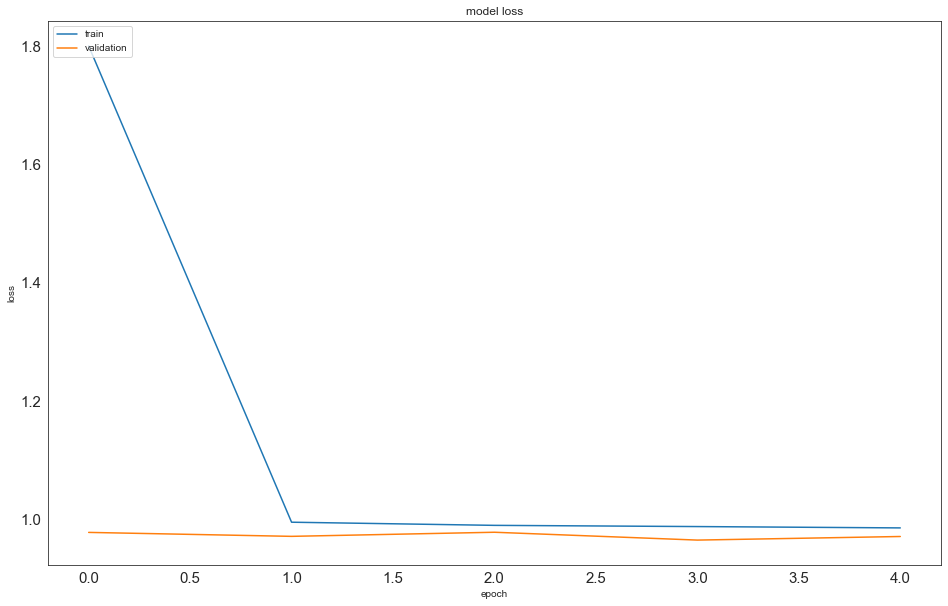

In [373]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [374]:
nn_predictions = nn_model.predict(X_test).reshape(-1,)
nn_predictions

array([13.379188, 13.505933, 13.394584, ..., 12.849461, 12.799938,
       13.191775], dtype=float32)

In [375]:
mean_absolute_percentage_error(nn_predictions, y_test)

0.06008219775599278

In [376]:
final_predictions_nn=np.expm1(nn_model.predict(predictions_df)).reshape(-1,)
final_predictions_nn

array([442484.53, 655763.25, 468722.75, ..., 710388.  , 479937.97,
       610609.25], dtype=float32)

In [360]:
prediccion_pycaret =  np.expm1(predict_model(blender, data=predictions_df)['Label'].values)
prediccion_pycaret

array([321383.16776628, 285508.3743464 , 330505.63636016, ...,
       366190.7357936 , 397045.65309671, 461819.01165092])

In [434]:
stack_prediction =  final_predictions_nn*0.0 +prediccion_pycaret*0.3 + nn_stack*0.4 + ensemble_submission['gasto_familiar'].values*0.3

In [455]:
submission = pd.concat([test_df['id_registro'],pd.Series(nn_stack)], axis=1)
submission.columns = ["id_registro", "gasto_familiar"]
submission['gasto_familiar'] = submission['gasto_familiar'].round(4)
#submission['gasto_familiar'] = np.where(submission['gasto_familiar'] > 10000000, 10000000, submission['gasto_familiar'])
submission

,id_registro,gasto_familiar
0,4055#201902,483094.12500
1,12598#201902,385636.37500
2,23697#201902,508392.18750
3,23768#201902,504419.03125
4,7174#201902,574859.00000
...,...,...
281661,8596193#202011,434353.34375
281662,8616083#202011,685246.43750
281663,8670207#202011,1196267.37500
281664,8677655#202011,736530.62500


In [456]:
submission['gasto_familiar'].describe()

count    281666.00000
mean     526231.81250
std      159132.65625
min      341715.40625
25%      424966.62500
50%      482177.00000
75%      562395.21875
max     1407961.00000
Name: gasto_familiar, dtype: float64

In [458]:
submission.to_csv("submission_underground_nn.csv", index=False)

# test

In [92]:
class PrepareSubmission:
    
    def __init__(self, dataframe, model):
        self.test_dataframe = dataframe
        self.model = model
     
    def makePrediction(self, dataframe)
        test_df_modeling = DataFramePreProcessor(test_df, test=True)
        test_df_modeling.process()
        final_predictions=xgb_reg.predict(test_df_modeling.modeling_dataframe[feature_cols])
    
    
    def prepareSubmissionDF(self, dataframe):
        submission = pd.concat([test_df['id_registro'],pd.Series(final_predictions)], axis=1)
        submission.columns = ["id_registro", "gasto_familiar"]
    
    
    def submit(self):
        submission.to_csv("submission_underground.csv", index=False)

# Compare predictions


In [53]:
best_submission = pd.read_csv("submission_underground XGB,CAT,LASSO,RIDGE,ELASTIC.csv")
best_submission_2 =  pd.read_csv("submission_underground XGBoost+17meses+Boxcox+Log.csv")

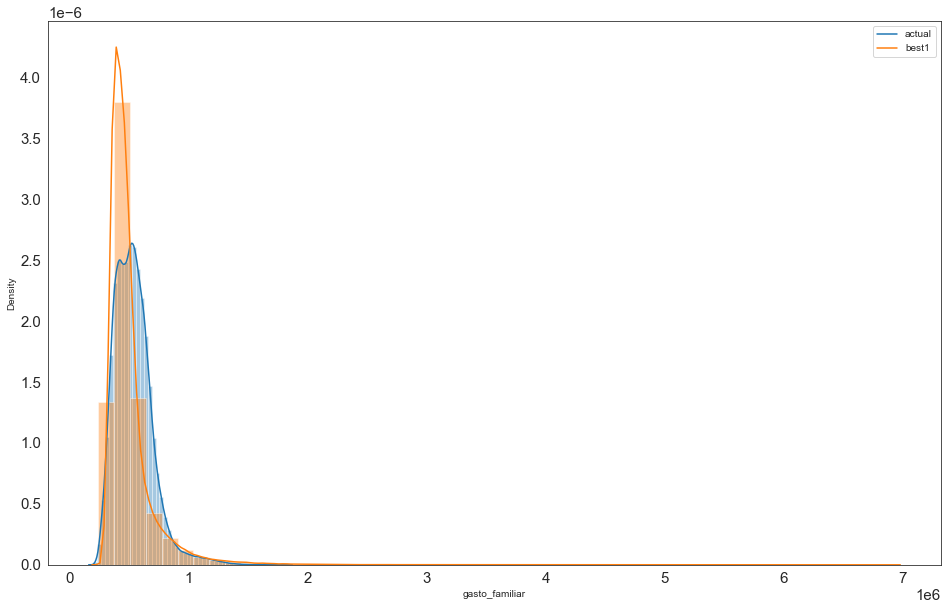

In [63]:
#sns.distplot(submission['gasto_familiar'])
#sns.distplot(fe_dataframe.modeling_dataframe['gasto_familiar'])
#sns.distplot(by_month[by_month['gasto_familiar'] < 10000000]['gasto_familiar'])
sns.distplot(ensemble_submission[ensemble_submission['gasto_familiar'] < 10000000]['gasto_familiar'])
#sns.distplot(ensemble_submission[ensemble_submission['gasto_familiar'] < 10000000]['gasto_familiar'])

#sns.distplot(best_submission_2[best_submission_2['gasto_familiar'] < 10000000]['gasto_familiar'])
sns.distplot(best_submission[best_submission['gasto_familiar'] < 10000000]['gasto_familiar'])

plt.legend(['actual','best1'])

In [164]:
best_submission['gasto_familiar'].describe()

count     281666.00000
mean      501804.50073
std       211217.20308
min       238665.81880
25%       388865.94178
50%       449492.94245
75%       532997.98152
max     11663100.22080
Name: gasto_familiar, dtype: float64

In [98]:
submission['gasto_familiar'].describe()

count   281666.00000
mean    263382.59375
std      91717.97656
min      87204.88281
25%     192228.77344
50%     242203.96875
75%     317857.34375
max     528016.50000
Name: gasto_familiar, dtype: float64

In [ ]:
def submit_predictions(name,model):
    df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_features.csv'), 
                                   index_col='match_id_hash')
    X_test = df_test_features.values
    y_test_pred = model.predict_proba(X_test)[:, 1]

    df_submission = pd.DataFrame({'radiant_win_prob': y_test_pred}, 
                                 index=df_test_features.index)
    submission_filename = 'submission_{}.csv'.format(name)
    df_submission.to_csv(submission_filename)
    print('Submission saved to {}'.format(submission_filename))
    
submit_predictions('simple_cat_boost',model=base_model)


In [270]:
np.log(104107969.83870)

18.46093909010424

In [92]:
test_df = pd.read_csv("test_cleaned.csv")
test_df.describe()

,periodo,id_cli,edad,ult_actual,categoria,cupo_total_tc,tenencia_tc,cuota_tc_bancolombia,tiene_consumo,tiene_crediagil,nro_tot_cuentas,ctas_activas,tiene_ctas_activas,cuota_cred_hipot,mediana_nom3,mediana_pen3,ingreso_nompen,ingreso_final,cuota_de_vivienda,cuota_de_consumo,cuota_rotativos,cuota_tarjeta_de_credito,cuota_de_sector_solidario,cuota_sector_real_comercio,cupo_tc_mdo,saldo_prom3_tdc_mdo,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,ind,ingreso_nomina,ingreso_segurida_social
count,281666.00000,281666.00000,281666.00000,281666.00000,278342.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281666.00000,281649.00000,281666.00000,281666.00000
mean,201958.89462,3155829.92767,43.41788,20190943.09152,1.79986,8196255.87089,0.51845,322006.13747,0.15088,0.21082,1.17219,1.10740,0.00000,111714.15514,1957364.04748,245932.37596,2203296.42343,7397799.53717,268052.32517,784138.26926,47108.18132,563386.22695,56275.48231,293737.44080,11810728.66800,2574295.36017,486269.02431,28127996.32188,80019.08644,3.72976,2437947.67455,1399995.07587,1508924.90161
std,49.75518,2689026.26961,13.05021,7346.15766,0.87800,15538125.04347,0.49966,832681.59064,0.35793,0.40789,0.48166,0.41877,0.00000,456499.89207,3742354.88142,1190026.40745,3839006.42542,22958238.04918,1353839.22103,5342640.33205,228470.55669,1248331.62350,1247434.88877,4520844.63053,23035314.11074,7135565.88197,2213261.91365,76903777.20689,1164283.82483,3.78567,12583048.72155,2867816.34351,4012918.10949
min,201902.00000,42.00000,18.00000,20170127.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100000.42000,0.00000,-107595928.78000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1794038433.65000,0.00000,0.00000
25%,201907.00000,1055390.75000,33.00000,20190131.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2636367.75000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,434800.51000,0.00000,0.00000
50%,202001.00000,2262922.50000,40.00000,20190719.00000,2.00000,1400000.00000,1.00000,78300.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,204500.00000,4434182.50000,0.00000,0.00000,0.00000,268000.00000,0.00000,0.00000,3090000.00000,0.00000,0.00000,299000.00000,0.00000,3.00000,1470923.20000,0.00000,0.00000
75%,202007.00000,4458678.50000,52.00000,20200116.00000,2.00000,10000000.00000,1.00000,370000.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,2989619.05500,0.00000,3318742.50000,7547975.00000,0.00000,761447.25000,0.00000,656000.00000,0.00000,0.00000,13244000.00000,2003000.00000,293000.00000,23874750.00000,0.00000,5.00000,3125343.94500,2122120.22250,1656232.00000
max,202011.00000,8704801.00000,100.00000,20201019.00000,5.00000,637200000.00000,1.00000,118705849.69500,1.00000,1.00000,14.00000,14.00000,0.00000,26140248.65953,448610998.00000,27517795.84000,448610998.00000,6678545038.44000,572309000.00000,1795444000.00000,10800000.00000,93199000.00000,289795000.00000,1116906000.00000,677635000.00000,275864000.00000,207013000.00000,6751272000.00000,300125000.00000,105.00000,558682865.36250,180912960.00000,311957565.00000
